# Distribution of Coalescent times under differing population histories

This is a notebook to outline problems I am having. I will present this in self-contained way so that it is reproducible. I refer entirely to notation and equations as in the journal _"On the importance of being structured: instantaneouscoalescence rates and human evolution—lessons for ancestral population size inference?"_ by O Mazet, W Rodriguez, S Grusea, S Boitard, and L Chikhi.

## Setup

These are the dependencies and functions needed, can skip over.

In [22]:
# dependencies

import os
from datetime import datetime
import argparse
import numpy as np
import pdb
import math#
import pandas as pd
from scipy.stats import entropy
import argparse
import matplotlib.pyplot as plt
import numpy as np
import msprime

# change plot size
plt.rcParams['figure.figsize'] = [12, 8]

In this notebook I record the observed sequence of tMRCAs along a genome, as returned by msprime. The following functions in the below code block are the mechanisms to do that.

In [3]:
def get_coal_data(sim,bin_length):
    tmrca_data = [] # first tuple is index, second tuple is sequence interval, third tuple is tMRCA
    ind = 0 #index for binning
    for tree in sim.trees():
        tmrca_data.append((tree.index,tree.interval[1],tree.time(tree.parent(0))))
        ind = math.floor(tree.interval[1]/bin_length)
    return tmrca_data

def round_bin_coal_data(seq_length,tmrca_data,bin_length):
    coal_times = np.zeros(shape=(int(seq_length/bin_length))) # create empty array which will store the binned coalescent times
    ind = 0 #index for binning
    for i in range(0,len(tmrca_data)):
        coal_times[ind:math.floor(tmrca_data[i][1]/bin_length)] = tmrca_data[i][2]
        ind = math.floor(tmrca_data[i][1]/bin_length)
    return coal_times

def round_coal_times(coal_times,T_scaled_np,N_T):
    # coal_times are the (exact) coalescent times along a sequence, as given by ms prime
    # T_scaled_np are the scaled time intervals (in a np aray)
    # N_T is the number of hidden states
    coal_times_intervals = [] 
    for i in range(0,len(coal_times)):
        diff = coal_times[i] - T_scaled_np
        diff_pos = diff[diff >0]
        where = np.argmin(diff_pos) # find closest interval
        if where == N_T: #TODO find a better fix for this. Have extended T to include upper interval
            where = where - 1
        coal_times_intervals.append(where) 
    return coal_times_intervals

def num_occcurences(array,time_intervals):
    counts = np.zeros(shape=len(time_intervals))
    for i in range(len(array)):
        counts[array[i]] += 1
    return counts

def get_counts_freq(sim,time_intervals,bin_length):
    # this function returns the observed pdf of T2 (f_T2(t))

    # get true coalescent data
    tmrca_data = get_coal_data(sim, bin_length) 

    # round this data into segments of size args.bin_length 
    coal_times = round_bin_coal_data(sim.sequence_length,tmrca_data, bin_length) # partition coalescent data into bins  


    # round coalescence time into interval
    coal_times_intervals = np.array(round_coal_times(coal_times,time_intervals,N_T=len(time_intervals))) # round binned coalescent times into their respected interval

    # count number of occurunces in each interval
    counts = num_occcurences(coal_times_intervals,time_intervals)

    # get frequency of these (divide by sum). This is the pdf (=f_T2(t))
    counts_freq = counts / counts.sum()
    return counts_freq

## Panmictic population of constant size

In [29]:
# run simulation
seq_length = 150e+06


print("Running simulation")
sim0 = panmictic_const(seq_length)
print("Simulation finished")

Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Simulation finished


## Population size changes over time

I first demonstrate that things work for a population that experiences size changes over time. 

I will create a history that doubles in size at time T_1 then returns to normal size at time T_2.

In [4]:
# define history
def psc(T_1,T_2,seq_length):
    N_0 = 1e+04 # diploid population size
    population_configurations = [
        msprime.PopulationConfiguration(sample_size=2, initial_size=N_0, growth_rate=0),
    ]
    demographic_events = [
        msprime.PopulationParametersChange(time=T_1, initial_size=N_0*2),
        msprime.PopulationParametersChange(time=T_2, initial_size=N_0)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

# define history
def panmictic_const(seq_length):
    N_0 = 1e+04 # diploid population size
    population_configurations = [
        msprime.PopulationConfiguration(sample_size=2, initial_size=N_0, growth_rate=0),
    ]
    demographic_events = []
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

In [59]:
# run simulation
seq_length = 150e+06
T_1 = 20000
T_2 = 50000

print("Running simulation")
sim1 = psc(T_1,T_2,seq_length)
print("Simulation finished")

Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Events @ generation 20000.0
   - Population parameter change for -1: initial_size -> 20000.0 
Epoch: 20000.0 -- 50000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  2e+04    2e+04               0 |     0    

Events @ generation 50000.0
   - Population parameter change for -1: initial_size -> 10000.0 
Epoch: 50000.0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Simulation finished


To measure the observed distribution, we must count number of coalescences in particular time intervals. 
When we consider the analytical expectation, we must scale these by some number (a linear function of bin_length, sequence_length, number and spacing of time intervals and something else that I can't figure out) which i can estimate hueristically, to match the observations

In [8]:
min_time = 0
max_time = 3e+05
spacing = 1000
bin_length = 100
seq_length = 150e+06
time_intervals = np.arange(min_time,max_time,spacing)

# scaling
scaling = 250*len(time_intervals)*(bin_length/seq_length)

Now record the observations, using the functions we defined earlier.

In [61]:
f_obs1 = get_counts_freq(sim1,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size

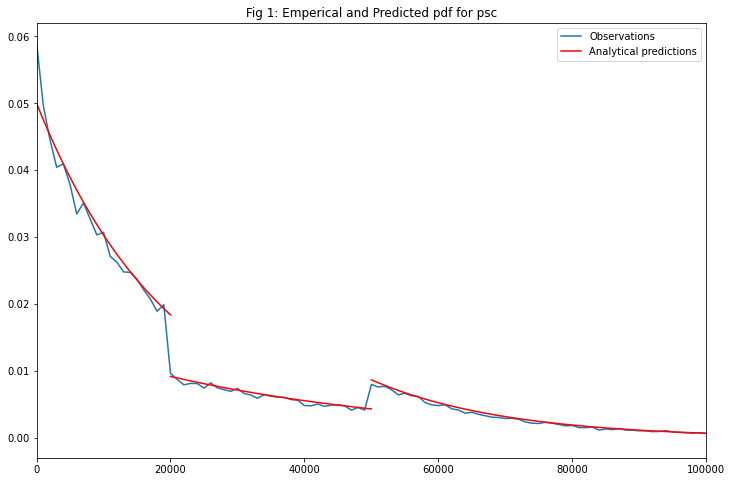

In [107]:
# standard pdf
def f1(x,N):
    x = x/(2*N)
    f = np.exp(-x)
    return f*scaling

def f2(x,T_1,N):
    x = x/(2*N)
    T_1 = T_1/(2*N)
    bigger_T_1 = np.exp(-T_1)
    f = bigger_T_1 * 0.5*np.exp(-(x-T_1)/2)
    return f*scaling

def f3(x,T_1,T_2,N):
    x = x/(2*N)
    T_1 = T_1/(2*N)
    T_2 = T_2/(2*N)
    bigger_T_2 = np.exp(-T_1)*(1 - (1-np.exp(-(T_2-T_1)/2)))
    f = bigger_T_2 * np.exp(-(x-T_2))
    return f*scaling
    
t1 = np.arange(0,T_1,1) # first epoch
t2 = np.arange(T_1,T_2,1) # second epoch
t3 = np.arange(T_2,max_time,1) # third epoch


N = 10000 # diploid population size

line_obs = plt.plot(time_intervals,f_obs1,label="Observations")
line_f1 = plt.plot(t1,f1(t1,N),label="Analytical predictions",color="red")
line_f2 = plt.plot(t2,f2(t2,T_1,N),color="red")
line_f3 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for psc')
plt.show()

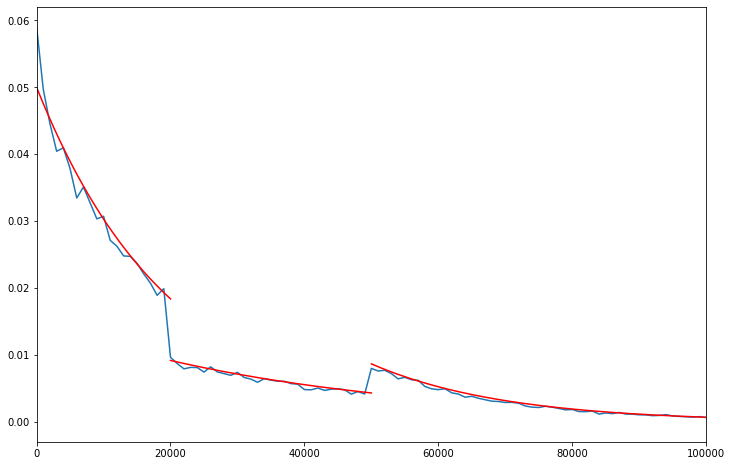

In [122]:
line_obs = plt.plot(time_intervals,f_obs1,label="Observations")

def ef1(x):
    x = x/20000
    return np.exp(-x)*scaling

def ef2(x,T_1):
    x = x/20000
    T_1 = T_1/20000
    f = np.exp(-T_1)*0.5*np.exp(-0.5*(x-T_1))
    return f*scaling

def ef3(x,T_1,T_2):
    x = x/20000
    T_1 = T_1/20000
    T_2 = T_2/20000
    f = np.exp(-T_1)*np.exp(-(T_2-T_1)/2)*np.exp(-(x-T_2))
    return f*scaling



line_f1 = plt.plot(t1,ef1(t1),label="Analytical predictions",color="red")
line_f1 = plt.plot(t2,ef2(t2,T_1),label="Analytical predictions",color="red")
line_f1 = plt.plot(t3,ef3(t3,T_1,T_2),label="Analytical predictions",color="red")


plt.xlim(0,100000)
plt.show()

As one can see, the predictions fit the observations well.

From here, it is easy to calculate F (the CDF) and the IICR.

TODO: do this (F and ICR)

## Population experiencing structure, at time = 0

Now I will try to fit the pdf for a history that experienced structure.

### Same deme

I will follow the n-island model, with 2 islands and sampling initially from the same deme. I use the notation as given in the manuscript mentioned above. 


In [4]:
def structure_samedeme(mig_rate,N,T_1,T_2,seq_length):
    N_A0 = N
    N_B0 =  N
    m = mig_rate
    
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A0, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N_B0, growth_rate=0)
    ]
    migration_matrix = [[0,0],[0,0]]
    demographic_events = [
        msprime.MigrationRateChange(time = T_1,rate = m, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_1,rate = m, matrix_index=(1,0)),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(1,0)),        
        msprime.MassMigration(time=T_2, source =1, destination =0, proportion = 1)
    ]
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,migration_matrix=migration_matrix,
        demographic_events=demographic_events)

    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,mutation_rate=2e-08)
    return sim


In [98]:
# run simulation
seq_length = 150e+06
T_1 = 0
T_2 = 80000
mig_rate = 5e-05
N = 10000

print("Running simulation")
sim2 = structure_samedeme(mig_rate,N,T_1,T_2,seq_length)
print("Simulation finished")

Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Events @ generation 0
   - Migration rate change for (0, 1) to 5e-05
   - Migration rate change for (1, 0) to 5e-05
Epoch: 0 -- 0.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Epoch: 0.0 -- 80000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0      5e-05  
1 |  1e+04    1e+04               0 |   5e-05      0    

Events @ generation 80000.0
   - Migration rate change for (0, 1) to 0
   - Migration rate change for (1, 0) to 0
   - Mass migration: Lineages moved with probability 1 backwards in time with source 1 & dest 0
                     (equivalent to migration from 0 to 1 forwards in time)
Epo

Record observations

In [251]:
f_obs2 = get_counts_freq(sim2,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs2 = [sum(f_obs2[0:t]) for t in range(len(f_obs2))] # this returns the CDF of T2 ( F_T2(t) )
iCR_obs2 = [spacing*(1-F_obs2[i])/(2*f_obs2[i]) for i in range(len(f_obs2)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


counts.sum() is 1500000.0


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


M, gamma, theta, discriminant, alpha, beta, a, c are [2.0, 2.0, 0.0008, 17.0, 4.561552812808831, 0.4384471871911697, 0.6212678125181664, -0.4850712500726658]


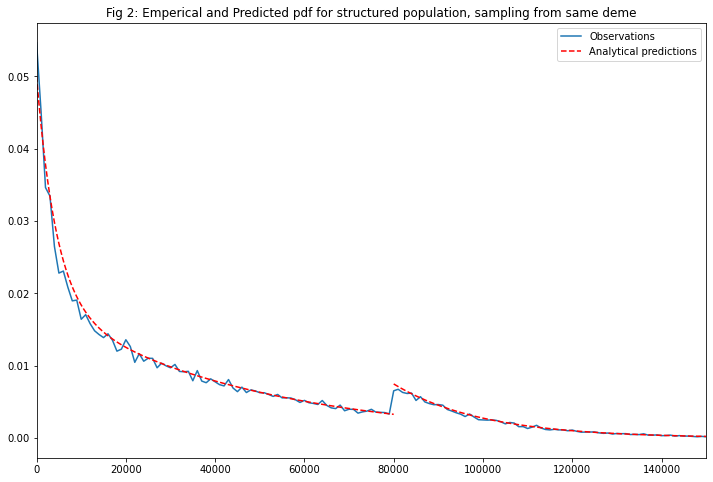

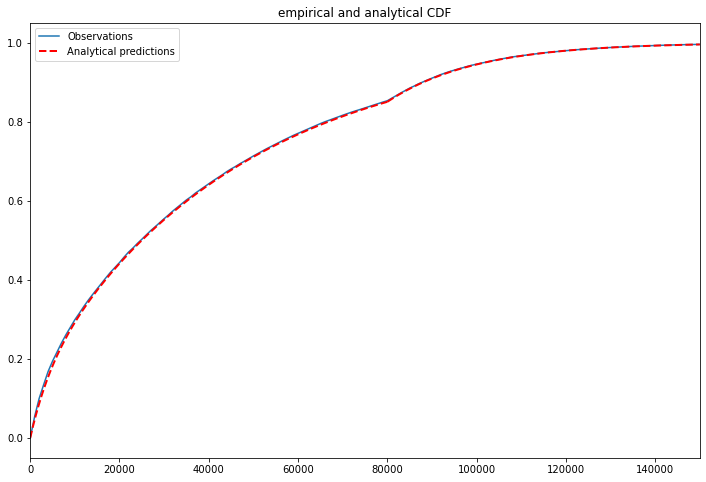

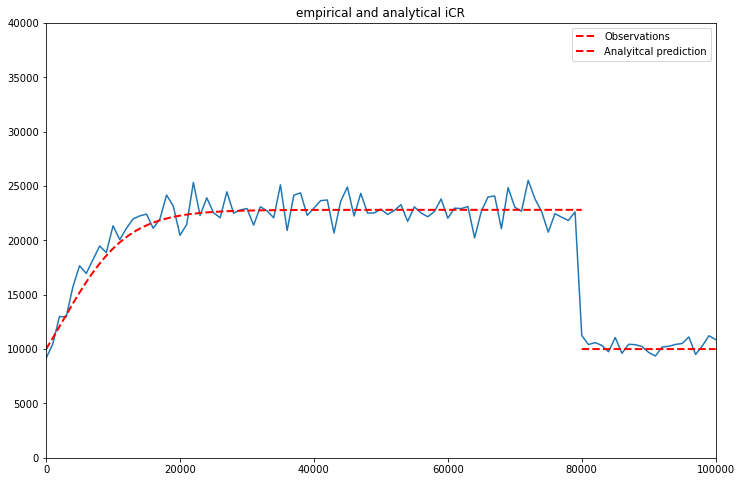

In [258]:
# set up parameters

N = 20000 # haploid genomes 

# n is number of demes
n = 2

# m is migration rate
m = mig_rate

# n is number of islands
n = 2

M = 2*N*m

gamma = M/(n-1)

mu = 2e-08

theta = 2 * N * mu 

discriminant = (1+n*gamma)**2 - 4*gamma

alpha = 0.5*(1 + n*gamma + np.sqrt(discriminant))

beta = 0.5*(1 + n*gamma - np.sqrt(discriminant))

a = (gamma-alpha)/(beta-alpha)

c = gamma/(beta-alpha)

print('M, gamma, theta, discriminant, alpha, beta, a, c are {}'.format([M, gamma, theta, discriminant, alpha, beta, a, c]))

# equation 10
def f_samedeme1(x,a,alpha,beta,N):
    # if j is generations, do we scale with j/(number of haploid genomes) or ((num of demes)*j)/(number of haploid genomes)
    # i.e. x = j/N or x = (n*j)/N 
    # I tried both, neither fits data
    x = (x)/(N) 
    f = a*np.exp(-alpha*x) + (1-a)*np.exp(-beta*x)
    return f*scaling

def F_samedeme1(x,a,alpha,beta,N):
    x = x/N
    F = 1 + ((-a/alpha)*np.exp(-alpha*x) - ((1-a)/beta)*np.exp(-beta*x)) 
    return F
    
def f_samedeme2(x,a,alpha,beta,N,T_2):
    x = x/N
    bigger_f1 = 1 - F_samedeme1(T_2,a,alpha,beta,N) 
    T_2 = T_2/N
    f = bigger_f1*np.exp(-(x-T_2))
    return f*scaling
    
def F_samedeme2(x,a,alpha,beta,N,T_2):
    x = x/N
    bigger_f1 = 1 - F_samedeme1(T_2,a,alpha,beta,N)
    F = F_samedeme1(T_2,a,alpha,beta,N) + (bigger_f1-bigger_f1*np.exp(-(x-T_2/N)))
    return F
    
def iCR1(x,a,alpha,beta,N):
    iCR = (1-F_samedeme1(x,a,alpha,beta,N))/(2*f_samedeme1(x,a,alpha,beta,N))*spacing
    return iCR

def iCR2(x,a,alpha,beta,N,T_2):
    iCR = (1-F_samedeme2(x,a,alpha,beta,N,T_2))/(2*f_samedeme2(x,a,alpha,beta,N,T_2))*spacing
    return iCR

t1 = np.arange(0,T_2,1) # first epoch
t2 = np.arange(T_2,max_time,1) # first epoch


line_f_obs = plt.plot(time_intervals,f_obs2,label="Observations")
line_f1 = plt.plot(t1,f_samedeme1(t1,a,alpha,beta,N),label="Analytical predictions",color="red",linestyle="dashed")
line_f2 = plt.plot(t2,f_samedeme2(t2,a,alpha,beta,N,T_2),color="red",linestyle="dashed")
# line_f3 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf for structured population, sampling from same deme')
plt.show()

line_F_obs = plt.plot(time_intervals,F_obs2,label="Observations")
line_F1 = plt.plot(t1,F_samedeme1(t1,a,alpha,beta,N),color = "red",label="Analytical predictions",linestyle="dashed",linewidth=2)
plt.plot(t2,F_samedeme2(t2,a,alpha,beta,N,T_2),color = "red",linestyle="dashed",linewidth=2)
plt.title('empirical and analytical CDF')
plt.legend()
plt.xlim(0,150000)
plt.show()

line_ICR_obs = plt.plot(time_intervals,iCR_obs2)
line_ICR1 = plt.plot(t1,iCR1(t1,a,alpha,beta,N),color = "red",linestyle="dashed",linewidth=2,label="Observations")
plt.plot(t2,iCR2(t2,a,alpha,beta,N,T_2),color = "red",linestyle="dashed",linewidth=2,label="Analyitcal prediction")
plt.xlim(0,100000)
plt.ylim(0,40000)
plt.legend()
plt.title('empirical and analytical iCR')
plt.show()

### Different deme

Now i try with sampling from a different deme

In [5]:
def structure_diffdeme(mig_rate,N,T_1,T_2,seq_length):
    N_A0 = N
    N_B0 =  N
    m = mig_rate
    
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=1, initial_size=N_A0, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=1, initial_size=N_B0, growth_rate=0)
    ]
    migration_matrix = [[0,0],[0,0]]
    demographic_events = [
        msprime.MigrationRateChange(time = T_1,rate = m, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_1,rate = m, matrix_index=(1,0)),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(1,0)),        
        msprime.MassMigration(time=T_2, source =1, destination =0, proportion = 1)
    ]
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,migration_matrix=migration_matrix,
        demographic_events=demographic_events)

    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,mutation_rate=2e-08)
    return sim

In [139]:
# run simulation
seq_length = 150e+06
T_1 = 0
T_2 = 80000
mig_rate = 5e-05
N = 10000

print("Running simulation")
sim3 = structure_diffdeme(mig_rate,N,T_1,T_2,seq_length)
print("Simulation finished")

Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Events @ generation 0
   - Migration rate change for (0, 1) to 5e-05
   - Migration rate change for (1, 0) to 5e-05
Epoch: 0 -- 0.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Epoch: 0.0 -- 80000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0      5e-05  
1 |  1e+04    1e+04               0 |   5e-05      0    

Events @ generation 80000.0
   - Migration rate change for (0, 1) to 0
   - Migration rate change for (1, 0) to 0
   - Mass migration: Lineages moved with probability 1 backwards in time with source 1 & dest 0
                     (equivalent to migration from 0 to 1 forwards in time)
Epo

In [264]:
f_obs3 = get_counts_freq(sim3,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs3 = [sum(f_obs3[0:t]) for t in range(len(f_obs3))] # this returns the CDF of T2 ( F_T2(t) )
iCR_obs3 = [spacing*(1-F_obs3[i])/(2*f_obs3[i]) for i in range(len(f_obs3)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


counts.sum() is 1500000.0


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


M, gamma, theta, discriminant, alpha, beta, a, c are [2.0, 2.0, 0.0008, 17.0, 4.561552812808831, 0.4384471871911697, 0.6212678125181664, -0.4850712500726658]


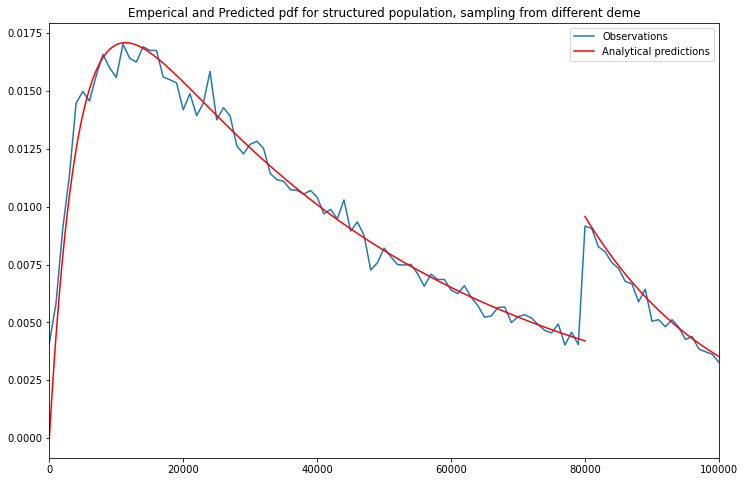

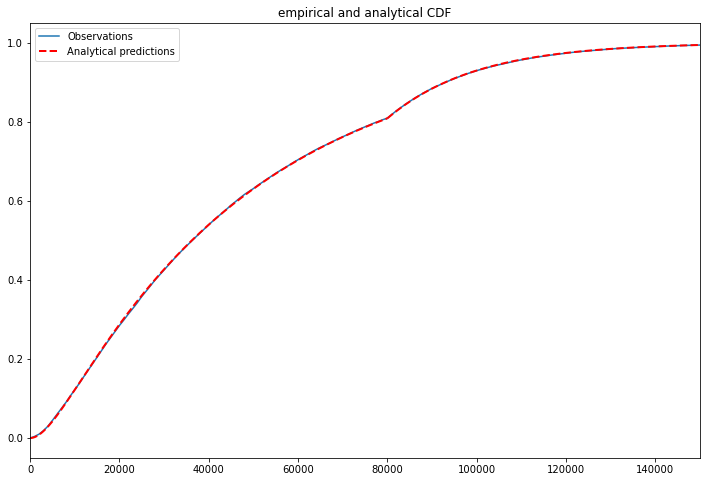

/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide


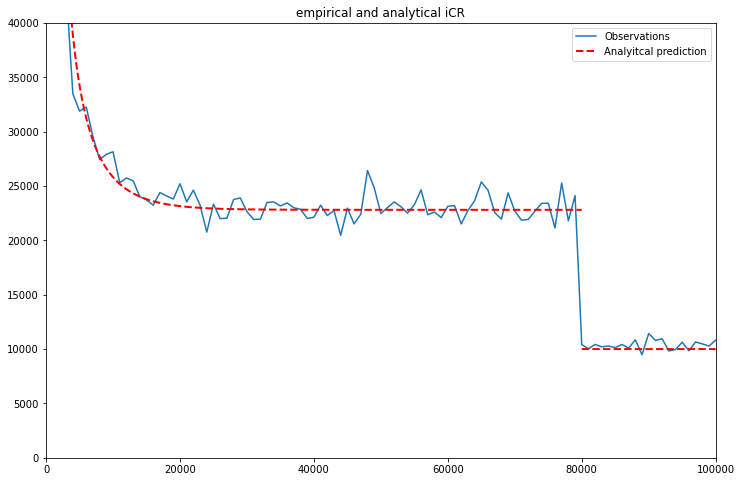

In [267]:
# set up parameters

# number of haploid genomes
N = 20000

# n is number of demes
n = 2

# N is population size of deme

# m is migration rate
m = mig_rate

# n is number of islands
n = 2

M = 2*N*m

gamma = M/(n-1)

mu = 2e-08

theta = 2 * N * mu 

discriminant = (1+n*gamma)**2 - 4*gamma

alpha = 0.5*(1 + n*gamma + np.sqrt(discriminant))

beta = 0.5*(1 + n*gamma - np.sqrt(discriminant))

a = (gamma-alpha)/(beta-alpha)

c = gamma/(beta-alpha)

print('M, gamma, theta, discriminant, alpha, beta, a, c are {}'.format([M, gamma, theta, discriminant, alpha, beta, a, c]))

# equation 11
def f_diffdeme1(x,c,alpha,beta,N):
    # do we scaled with j/N or (n*j)/N
    x = (x)/N 
    f = c*np.exp(-alpha*x) - c*np.exp(-beta*x)
    return f*scaling


def F_diffdeme1(x,c,alpha,beta,N):
    x = x/N
    F = 1 + ((-c/alpha)*np.exp(-alpha*x) + (c/beta)*np.exp(-beta*x)) 
    return F
    
def f_diffdeme2(x,c,alpha,beta,N,T_2):
    x = x/N
    bigger_f1 = 1 - F_diffdeme1(T_2,c,alpha,beta,N) 
    T_2 = T_2/N
    f = bigger_f1*np.exp(-(x-T_2))
    return f*scaling
    
def F_diffdeme2(x,c,alpha,beta,N,T_2):
    x = x/N
    bigger_f1 = 1 - F_diffdeme1(T_2,c,alpha,beta,N)
    F = F_diffdeme1(T_2,c,alpha,beta,N) + (bigger_f1-bigger_f1*np.exp(-(x-T_2/N)))
    return F
    
def iCR1(x,c,alpha,beta,N):
    iCR = (1-F_diffdeme1(x,c,alpha,beta,N))/(2*f_diffdeme1(x,c,alpha,beta,N))*spacing
    return iCR

def iCR2(x,c,alpha,beta,N,T_2):
    iCR = (1-F_diffdeme2(x,c,alpha,beta,N,T_2))/(2*f_diffdeme2(x,c,alpha,beta,N,T_2))*spacing
    return iCR


t1 = np.arange(0,T_2,1) # first epoch
t2 = np.arange(T_2,max_time,1) # first epoch

line_obs = plt.plot(time_intervals,f_obs3,label="Observations")
line_f1 = plt.plot(t1,f_diffdeme1(t1,c,alpha,beta,N),label="Analytical predictions",color="red")
line_f2 = plt.plot(t2,f_diffdeme2(t2,c,alpha,beta,N,T_2),color="red")
# line_f3 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,100000)
plt.title('Emperical and Predicted pdf for structured population, sampling from different deme')
plt.show()


line_F_obs = plt.plot(time_intervals,F_obs3,label="Observations")
line_F1 = plt.plot(t1,F_diffdeme1(t1,c,alpha,beta,N),color = "red",label="Analytical predictions",linestyle="dashed",linewidth=2)
plt.plot(t2,F_diffdeme2(t2,c,alpha,beta,N,T_2),color = "red",linestyle="dashed",linewidth=2)
plt.title('empirical and analytical CDF')
plt.legend()
plt.xlim(0,150000)
plt.show()

line_ICR_obs = plt.plot(time_intervals,iCR_obs3,label="Observations")
line_ICR1 = plt.plot(t1,iCR1(t1,c,alpha,beta,N),color = "red",linestyle="dashed",linewidth=2,label="Analyitcal prediction")
plt.plot(t2,iCR2(t2,c,alpha,beta,N,T_2),color = "red",linestyle="dashed",linewidth=2)
plt.xlim(0,100000)
plt.ylim(0,40000)
plt.legend()
plt.title('empirical and analytical iCR')
plt.show()

## Population Experiencing Structure, between times T1 and T2

Contrary to the previous sections, now I create a history that is structured between two time points, not at 0 as before

### Same deme

Start with sampling from the same deme

In [268]:
# run simulation
seq_length = 150e+06
T_1 = 20000
T_2 = 50000
mig_rate = 5e-05
N = 10000 # diploid size

print("Running simulation")
sim4 = structure_samedeme(mig_rate,N,T_1,T_2,seq_length)
print("Simulation finished")

Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 20000.0
   - Migration rate change for (0, 1) to 5e-05
   - Migration rate change for (1, 0) to 5e-05
Epoch: 20000.0 -- 50000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0      5e-05  
1 |  1e+04    1e+04               0 |   5e-05      0    

Events @ generation 50000.0
   - Migration rate change for (0, 1) to 0
   - Migration rate change for (1, 0) to 0
   - Mass migration: Lineages moved with probability 1 backwards in time with source 1 & dest 0
                     (equivalent to migration from 0 to 1 forward

In [269]:
f_obs4 = get_counts_freq(sim4,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs4 = [sum(f_obs4[0:t]) for t in range(len(f_obs4))] # this returns the CDF of T2 ( F_T2(t) )
iCR_obs4 = [spacing*(1-F_obs4[i])/(2*f_obs4[i]) for i in range(len(f_obs4)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


counts.sum() is 1500000.0


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


M, gamma, theta, discriminant, alpha, beta, a, c are [2.0, 2.0, 0.0008, 17.0, 4.561552812808831, 0.4384471871911697, 0.6212678125181664, -0.4850712500726658]


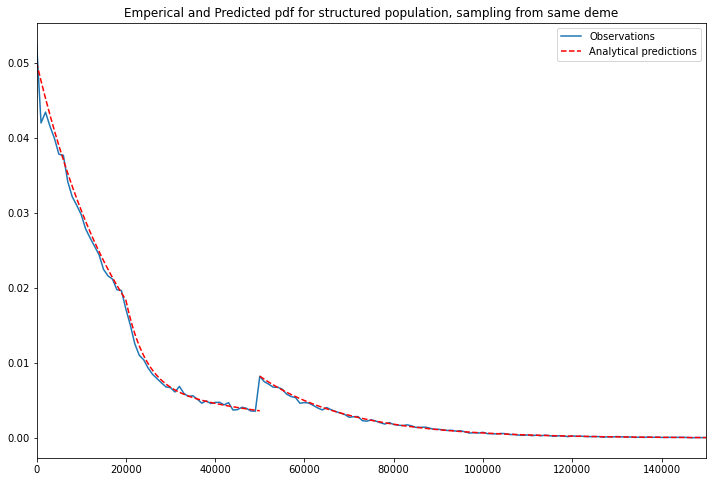

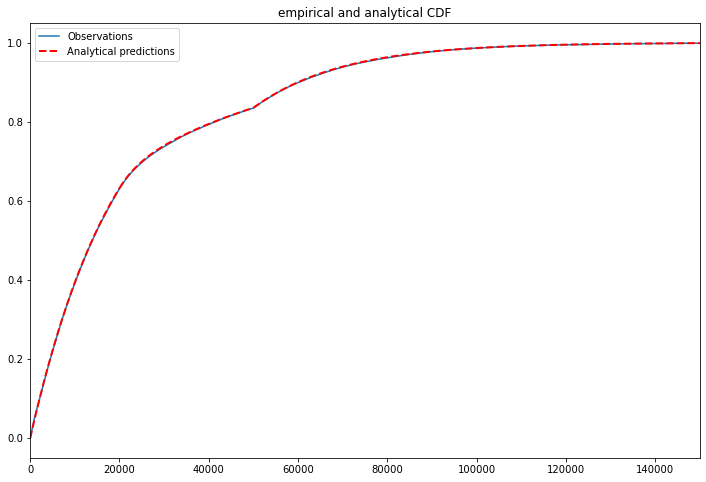

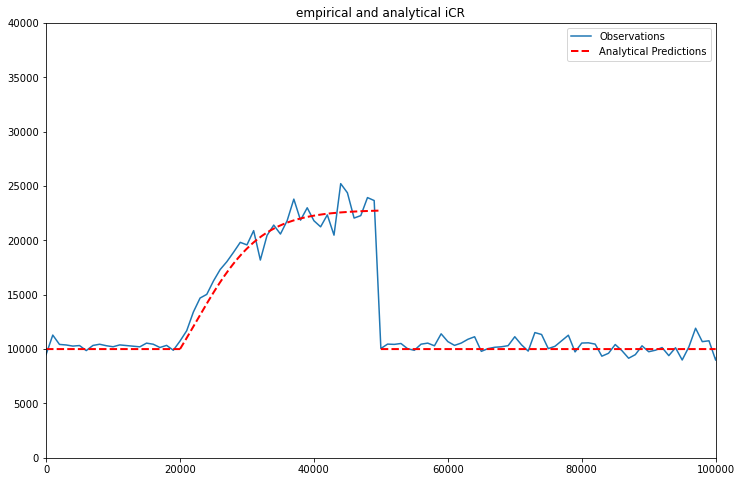

In [308]:
# set up parameters

N = 20000 # haploid genomes 

# n is number of demes
n = 2

# m is migration rate
m = mig_rate

# n is number of islands
n = 2

M = 2*N*m

gamma = M/(n-1)

mu = 2e-08

theta = 2 * N * mu 

discriminant = (1+n*gamma)**2 - 4*gamma

alpha = 0.5*(1 + n*gamma + np.sqrt(discriminant))

beta = 0.5*(1 + n*gamma - np.sqrt(discriminant))

a = (gamma-alpha)/(beta-alpha)

c = gamma/(beta-alpha)

print('M, gamma, theta, discriminant, alpha, beta, a, c are {}'.format([M, gamma, theta, discriminant, alpha, beta, a, c]))

def f_samedeme0(x,N):
    x = x/N
    f = np.exp(-x)
    return f*scaling

def F_samedeme0(x,N):
    x = x/N
    F = 1- np.exp(-x)
    return F

# equation 10
def f_samedeme1(x,a,alpha,beta,N,T_1):
    # if j is generations, do we scale with j/(number of haploid genomes) or ((num of demes)*j)/(number of haploid genomes)
    # i.e. x = j/N or x = (n*j)/N 
    # I tried both, neither fits data
    x = (x-T_1)/(N)
    bigger_f0 = 1 - F_samedeme0(T_1,N)
    T_1 = T_1/N
    f = a*np.exp(-alpha*x) + (1-a)*np.exp(-beta*x)
    return bigger_f0*f*scaling

def F_samedeme1(x,a,alpha,beta,N,T_1):
    x = (x-T_1)/N
    bigger_f0 = 1 - F_samedeme0(T_1,N)
    F = F_samedeme0(T_1,N) + (bigger_f0 + bigger_f0*((-a/alpha)*np.exp(-alpha*x) - ((1-a)/beta)*np.exp(-beta*x))) 
    return F
    
def f_samedeme2(x,a,alpha,beta,N,T_1,T_2):
    x = x/N
    bigger_f1 = 1 - F_samedeme1(T_2,a,alpha,beta,N,T_1) 
    T_2 = T_2/N
    f = bigger_f1*np.exp(-(x-T_2))
    return f*scaling
    
def F_samedeme2(x,a,alpha,beta,N,T_1,T_2):
    x = x/N
    bigger_f1 = 1 - F_samedeme1(T_2,a,alpha,beta,N,T_1)
    F = F_samedeme1(T_2,a,alpha,beta,N,T_1) + (bigger_f1-bigger_f1*np.exp(-(x-T_2/N)))
    return F

def iCR0(x,N):
    iCR = (1-F_samedeme0(x,N))/(2*f_samedeme0(x,N))*spacing
    return iCR

def iCR1(x,a,alpha,beta,N,T_1):
    iCR = (1-F_samedeme1(x,a,alpha,beta,N,T_1))/(2*f_samedeme1(x,a,alpha,beta,N,T_1))*spacing
    return iCR

def iCR2(x,a,alpha,beta,N,T_1,T_2):
    iCR = (1-F_samedeme2(x,a,alpha,beta,N,T_1,T_2))/(2*f_samedeme2(x,a,alpha,beta,N,T_1,T_2))*spacing
    return iCR

t1 = np.arange(0,T_1,1) # first epoch
t2 = np.arange(T_1,T_2,1) # first epoch
t3 = np.arange(T_2,max_time,1) # first epoch


line_f_obs = plt.plot(time_intervals,f_obs4,label="Observations")
line_f1 = plt.plot(t1,f_samedeme0(t1,N),label="Analytical predictions",color="red",linestyle="dashed")
line_f1 = plt.plot(t2,f_samedeme1(t2,a,alpha,beta,N,T_1),color="red",linestyle="dashed")
line_f2 = plt.plot(t3,f_samedeme2(t3,a,alpha,beta,N,T_1,T_2),color="red",linestyle="dashed")
# line_f3 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf for structured population, sampling from same deme')
plt.show()

line_F_obs = plt.plot(time_intervals,F_obs4,label="Observations")
line_F0 = plt.plot(t1,F_samedeme0(t1,N),color = "red",label="Analytical predictions",linestyle="dashed",linewidth=2)
plt.plot(t2,F_samedeme1(t2,a,alpha,beta,N,T_1),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t3,F_samedeme2(t3,a,alpha,beta,N,T_1,T_2),color = "red",linestyle="dashed",linewidth=2)
plt.title('empirical and analytical CDF')
plt.legend()
plt.xlim(0,150000)
plt.show()

line_ICR_obs = plt.plot(time_intervals,iCR_obs4,label="Observations")
line_ICR1 = plt.plot(t1,iCR0(t1,N),color = "red",linestyle="dashed",linewidth=2,label="Analytical Predictions")
plt.plot(t2,iCR1(t2,a,alpha,beta,N,T_1),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t3,iCR2(t3,a,alpha,beta,N,T_1,T_2),color = "red",linestyle="dashed",linewidth=2)
plt.xlim(0,100000)
plt.ylim(0,40000)
plt.legend()
plt.title('empirical and analytical iCR')
plt.show()

## Population Structure as population split

Now model a population that splits in to two sub populations at time T_1

In [5]:
def split(N,mig_prop,T_1,T_2,seq_length,):
    
    if not 0 < mig_prop < 1:
        print('Error. mig_prop is {} which is not between 0 and 1. Aborting\n'.format(mig_prop))
        sys.exit()
    print('N is {}'.format(N))
    print('mig_prop is {}'.format(mig_prop))
    print('t_1 is {} and t_2 is {}'.format(T_1,T_2))
    print('seq_length is {}'.format(seq_length))
    
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N, growth_rate=0),
    ]
    demographic_events = [
        msprime.MassMigration(time=T_1, source = 0, dest=1,proportion=mig_prop),
        msprime.MassMigration(time=T_2, source=1, dest=0, proportion=1)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

In [65]:
N = 1e+04
seq_length = 150e+06
mig_prop = 0.1
T_1 = 20000
T_2 = 60000



print("Running simulation")
sim5 = split(N,mig_prop,T_1,T_2,seq_length)
print("Simulation finished")


Running simulation
N is 10000.0
mig_prop is 0.1
t_1 is 20000 and t_2 is 60000
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 20000.0
   - Mass migration: Lineages moved with probability 0.1 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forwards in time)
Epoch: 20000.0 -- 60000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 60000.0
   - Mass migration: Lineages moved with probability 1 backwards in time with sour

In [127]:
f_obs5 = get_counts_freq(sim5,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs5 = [sum(f_obs5[0:t]) for t in range(len(f_obs5))] # this returns the CDF of T2 ( F_T2(t) )
iCR_obs5 = [spacing*(1-F_obs5[i])/(2*f_obs5[i]) for i in range(len(f_obs5)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)

/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


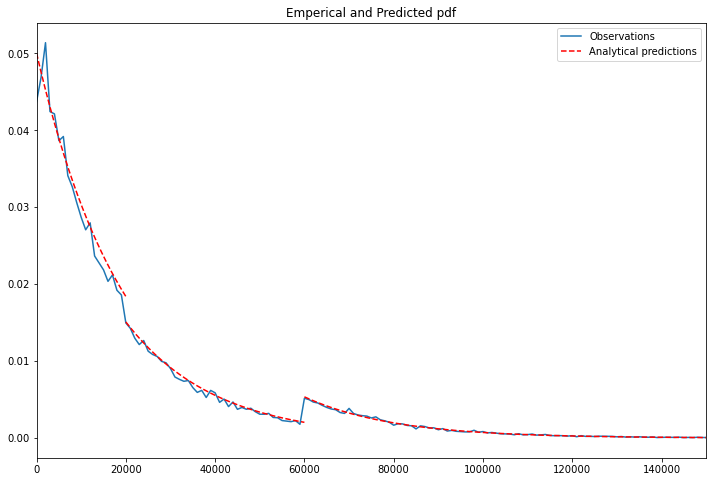

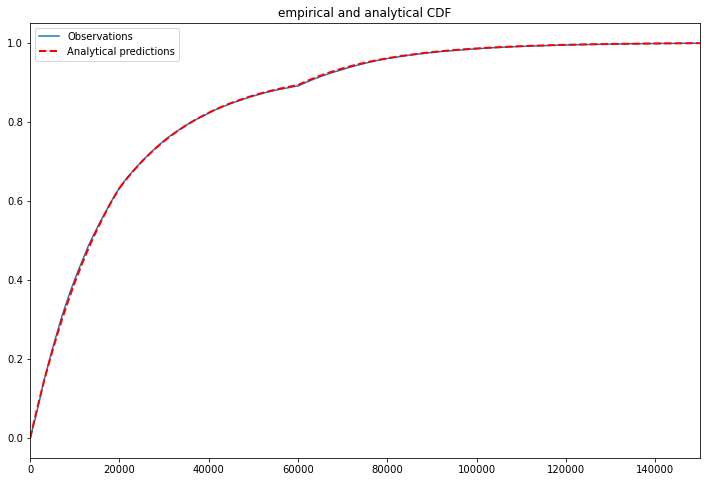

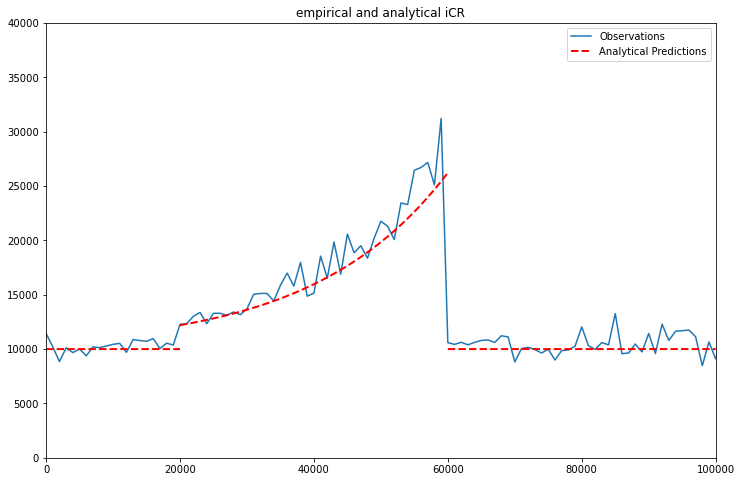

In [128]:

def f1(x,N):
    x = x/(2*N)
    f = np.exp(-x)
    return f*scaling

def F1(x,N):
    x = x/(2*N)
    F = 1-np.exp(-x)
    return F

def f2(x,mig_prop,T_1,N):
    x = (x)/(2*N)
    bigger_f1 = 1-F1(T_1,N)
    T_1 = T_1/(2*N)
    f = (mig_prop**2)*np.exp(-(x-T_1)) + ((1-mig_prop)**2)*1*np.exp(-(x-T_1)) 
    return bigger_f1*f*scaling 

# guess2 = 0

def F2(x,mig_prop,T_1,N):
    x = x/(2*N)
    bigger_f1 = 1-F1(T_1,N)
    T_1 = T_1 / (2*N)
    F = F1(T_1*2*N,N) + bigger_f1*(
        -(mig_prop**2)*np.exp(-(x-T_1)) - ((1-mig_prop)**2)*(np.exp(-(x-T_1)))
        -(-mig_prop**2 - (1-mig_prop)**2)
    )
    return F

def f3(x,mig_prop,T_1,T_2,N):
    x = x/(2*N)
    bigger_f2 = 1-F2(T_2,mig_prop,T_1,N)
    T_2 = T_2/(2*N)
    f = np.exp(-(x-T_2))
    return bigger_f2*f*scaling

def F3(x,mig_prop,T_1,T_2,N):
    x = x/(2*N)
    bigger_f2 = 1-F2(T_2,mig_prop,T_1,N)
    T_2 = T_2/(2*N)
    F = F2(T_2*(2*N),mig_prop,T_1,N) + bigger_f2*(
        (1-np.exp(-(x-T_2)))
    )
    return F

def iCR1(x,N):
    iCR = (1-F1(x,N))/(2*f1(x,N))
    return spacing*iCR

def iCR2(x,mig_prop,T_1,N):
    iCR = (1-F2(x,mig_prop,T_1,N))/(2*f2(x,mig_prop,T_1,N))
    return spacing*iCR

def iCR3(x,mig_prop,T_1,T_2,N):
    iCR = (1-F3(x,mig_prop,T_1,T_2,N))/(2*f3(x,mig_prop,T_1,T_2,N))
    return spacing*iCR



t1 = np.arange(0,T_1,1)
t2 = np.arange(T_1,T_2,1)
t3 = np.arange(T_2,max_time,1)

line_f_obs = plt.plot(time_intervals,f_obs5,label="Observations")
line_f1 = plt.plot(t1,f1(t1,N),label="Analytical predictions",color="red",linestyle="dashed")
line_f1 = plt.plot(t2,f2(t2,mig_prop,T_1,N),color="red",linestyle="dashed")
line_f2 = plt.plot(t3,f3(t3,mig_prop,T_1,T_2,N),color="red",linestyle="dashed")
# line_f3 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf')
plt.show()

line_F_obs = plt.plot(time_intervals,F_obs5,label="Observations")
line_F1 = plt.plot(t1,F1(t1,N),color = "red",label="Analytical predictions",linestyle="dashed",linewidth=2)
plt.plot(t2,F2(t2,mig_prop,T_1,N),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t3,F3(t3,mig_prop,T_1,T_2,N),color = "red",linestyle="dashed",linewidth=2)
plt.title('empirical and analytical CDF')
plt.legend()
plt.xlim(0,150000)
plt.show()

line_ICR_obs = plt.plot(time_intervals,iCR_obs5,label="Observations")
line_ICR1 = plt.plot(t1,iCR1(t1,N),color = "red",linestyle="dashed",linewidth=2,label="Analytical Predictions")
plt.plot(t2,iCR2(t2,mig_prop,T_1,N),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t3,iCR3(t3,mig_prop,T_1,T_2,N),color = "red",linestyle="dashed",linewidth=2)
plt.xlim(0,100000)
plt.ylim(0,40000)
plt.legend()
plt.title('empirical and analytical iCR')
plt.show()

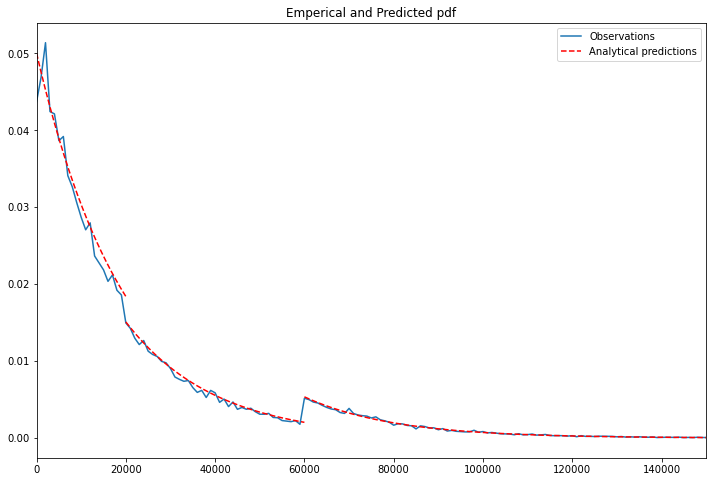

In [174]:
def ef1(x):
    x=x/20000
    f = np.exp(-x)
    return f*scaling

def ef2(x):
    x = x/20000
    f = (41/50)*np.exp(-x)
    return f*scaling

def ef3(x,T_1,T_2):
    x = x/20000
    T_1 = T_1/20000
    T_2 = T_2/20000
#     f = (41/50)*np.exp(-x)
#     print(np.exp(-T_1)*(41/50*(1-np.exp(-(T_2-T_1)))))
    f = np.exp(-T_1)*(1-(41/50 -41/50*np.exp(-(T_2-T_1))))*np.exp(-(x-T_2))
    return f*scaling

line_f_obs = plt.plot(time_intervals,f_obs5,label="Observations")
line_f1 = plt.plot(t1,ef1(t1),label="Analytical predictions",color="red",linestyle="dashed")
line_f1 = plt.plot(t2,ef2(t2),color="red",linestyle="dashed")
line_f2 = plt.plot(t3,ef3(t3,T_1,T_2),color="red",linestyle="dashed")
# line_f3 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf')
plt.show()


In [136]:
1/2*10

5.0

In [150]:
T_1 = 20000
T_2 = 60000

## Population Experience Structure between times T1 and T2 as well as population size change

In [7]:
def structure_samedeme_psc(mig_rate,change,N,T_1,T_2,seq_length):
    N_A0 = N
    N_B0 =  N
    m = mig_rate
    
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A0, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N_B0, growth_rate=0)
    ]
    migration_matrix = [[0,0],[0,0]]
    demographic_events = [
        msprime.MigrationRateChange(time = T_1,rate = m, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_1,rate = m, matrix_index=(1,0)),
        msprime.PopulationParametersChange(time=T_1, initial_size=N*change,population_id=0),
        msprime.PopulationParametersChange(time=T_1, initial_size=N*change,population_id=1),
        msprime.PopulationParametersChange(time=T_2, initial_size=N,population_id=0),
        msprime.PopulationParametersChange(time=T_2, initial_size=N,population_id=1),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(1,0)),        
        msprime.MassMigration(time=T_2, source =1, destination =0, proportion = 1)
    ]
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,migration_matrix=migration_matrix,
        demographic_events=demographic_events)

    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,mutation_rate=2e-08)
    return sim


In [353]:
# run simulation
seq_length = 150e+06
T_1 = 20000
T_2 = 50000
mig_rate = 5e-05
N = 10000
change = 2

print("Running simulation")
sim6 = structure_samedeme_psc(mig_rate,change,N,T_1,T_2,seq_length)
print("Simulation finished")

Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 20000.0
   - Migration rate change for (0, 1) to 5e-05
   - Migration rate change for (1, 0) to 5e-05
   - Population parameter change for 0: initial_size -> 20000 
   - Population parameter change for 1: initial_size -> 20000 
Epoch: 20000.0 -- 50000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  2e+04    2e+04               0 |     0      5e-05  
1 |  2e+04    2e+04               0 |   5e-05      0    

Events @ generation 50000.0
   - Population parameter change for 0: initial_size -> 10000 
   - Population parameter change for 1: initial_size -> 10

In [354]:
f_obs6 = get_counts_freq(sim6,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs6 = [sum(f_obs6[0:t]) for t in range(len(f_obs6))] # this returns the CDF of T2 ( F_T2(t) )
iCR_obs6 = [spacing*(1-F_obs6[i])/(2*f_obs6[i]) for i in range(len(f_obs4)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


M, gamma, theta, discriminant, alpha, beta, a, c are [4.0, 4.0, 0.0016, 65.0, 8.531128874149275, 0.46887112585072543, 0.5620173672946043, -0.49613893835683387]


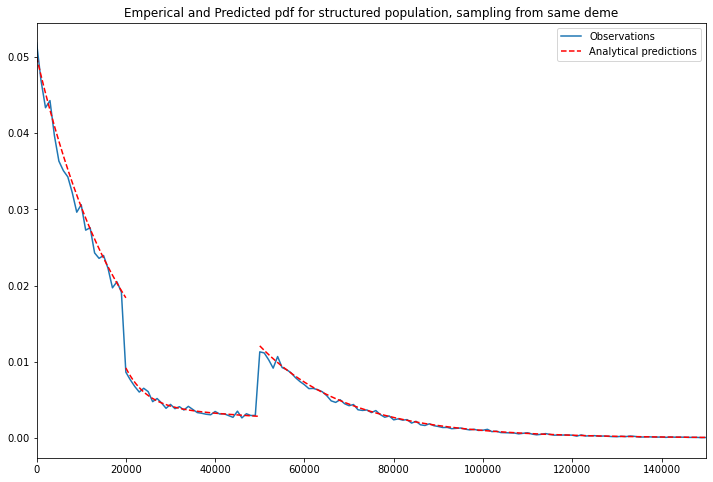

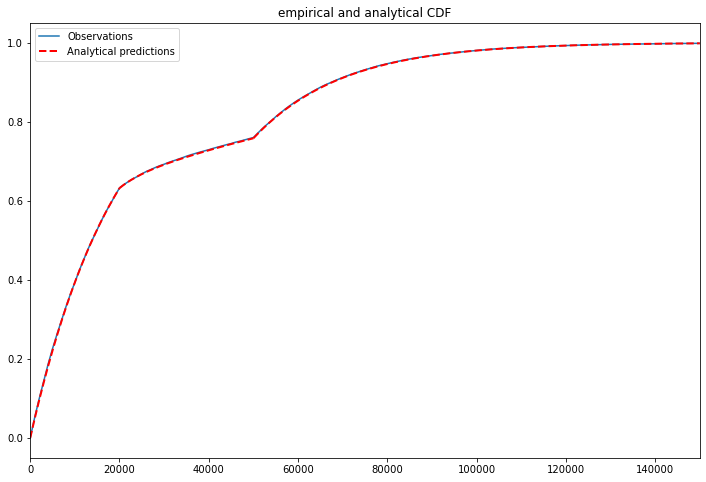

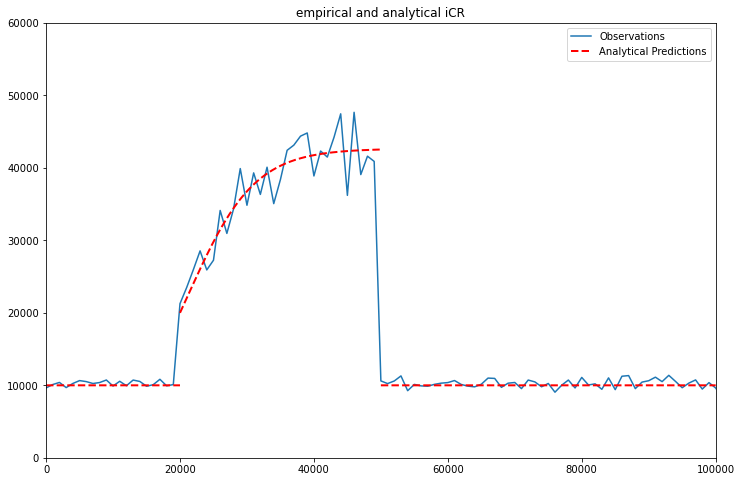

In [382]:
# set up parameters

N = 20000 # num of haploid genomes in epochs 1 and 3
N_s = 40000 # num of haploid genomes in epochs 2, when population size changes. Have to recalibrate model (eqs 10 and 11 from Mazet)

# n is number of demes
n = 2

# m is migration rate
m = mig_rate

# n is number of islands
n = 2

M = 2*N_s*m

gamma = M/(n-1)

mu = 2e-08

theta = 2 * N_s * mu 

discriminant = (1+n*gamma)**2 - 4*gamma

alpha = 0.5*(1 + n*gamma + np.sqrt(discriminant))

beta = 0.5*(1 + n*gamma - np.sqrt(discriminant))

a = (gamma-alpha)/(beta-alpha)

c = gamma/(beta-alpha)

print('M, gamma, theta, discriminant, alpha, beta, a, c are {}'.format([M, gamma, theta, discriminant, alpha, beta, a, c]))

def f_samedeme0(x,N):
    x = x/N
    f = np.exp(-x)
    return f*scaling

def F_samedeme0(x,N):
    x = x/N
    F = 1- np.exp(-x)
    return F

# equation 10
def f_samedeme1(x,a,alpha,beta,N,T_1):
    # if j is generations, do we scale with j/(number of haploid genomes) or ((num of demes)*j)/(number of haploid genomes)
    # i.e. x = j/N or x = (n*j)/N 
    # I tried both, neither fits data
    x = (x-T_1)/(N)
    bigger_f0 = 1 - F_samedeme0(T_1,N)
    T_1 = T_1/N
    f = 0.5*(a*np.exp(-(alpha*x)/2) + (1-a)*np.exp(-(beta*x)/2))
    return bigger_f0*f*scaling

def F_samedeme1(x,a,alpha,beta,N,T_1):
    x = (x-T_1)/N
    bigger_f0 = 1 - F_samedeme0(T_1,N)
    F = F_samedeme0(T_1,N) + (bigger_f0 + 0.5*bigger_f0*((-(2*a)/alpha)*np.exp(-(alpha*x)/2) - ((2*(1-a))/beta)*np.exp(-(beta*x)/2))) 
    return F
    
def f_samedeme2(x,a,alpha,beta,N,T_1,T_2):
    x = x/N
    bigger_f1 = 1 - F_samedeme1(T_2,a,alpha,beta,N,T_1) 
    T_2 = T_2/N
    f = bigger_f1*np.exp(-(x-T_2))
    return f*scaling
    
def F_samedeme2(x,a,alpha,beta,N,T_1,T_2):
    x = x/N
    bigger_f1 = 1 - F_samedeme1(T_2,a,alpha,beta,N,T_1)
    F = F_samedeme1(T_2,a,alpha,beta,N,T_1) + (bigger_f1-bigger_f1*np.exp(-(x-T_2/N)))
    return F

def iCR0(x,N):
    iCR = (1-F_samedeme0(x,N))/(2*f_samedeme0(x,N))*spacing
    return iCR

def iCR1(x,a,alpha,beta,N,T_1):
    iCR = (1-F_samedeme1(x,a,alpha,beta,N,T_1))/(2*f_samedeme1(x,a,alpha,beta,N,T_1))*spacing
    return iCR

def iCR2(x,a,alpha,beta,N,T_1,T_2):
    iCR = (1-F_samedeme2(x,a,alpha,beta,N,T_1,T_2))/(2*f_samedeme2(x,a,alpha,beta,N,T_1,T_2))*spacing
    return iCR

t1 = np.arange(0,T_1,1) # first epoch
t2 = np.arange(T_1,T_2,1) # first epoch
t3 = np.arange(T_2,max_time,1) # first epoch


line_f_obs = plt.plot(time_intervals,f_obs6,label="Observations")
line_f1 = plt.plot(t1,f_samedeme0(t1,N),label="Analytical predictions",color="red",linestyle="dashed")
line_f1 = plt.plot(t2,f_samedeme1(t2,a,alpha,beta,N,T_1),color="red",linestyle="dashed")
line_f2 = plt.plot(t3,f_samedeme2(t3,a,alpha,beta,N,T_1,T_2),color="red",linestyle="dashed")
# line_f3 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf for structured population, sampling from same deme')
plt.show()

line_F_obs = plt.plot(time_intervals,F_obs6,label="Observations")
line_F0 = plt.plot(t1,F_samedeme0(t1,N),color = "red",label="Analytical predictions",linestyle="dashed",linewidth=2)
plt.plot(t2,F_samedeme1(t2,a,alpha,beta,N,T_1),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t3,F_samedeme2(t3,a,alpha,beta,N,T_1,T_2),color = "red",linestyle="dashed",linewidth=2)
plt.title('empirical and analytical CDF')
plt.legend()
plt.xlim(0,150000)
plt.show()

line_ICR_obs = plt.plot(time_intervals,iCR_obs6,label="Observations")
line_ICR1 = plt.plot(t1,iCR0(t1,N),color = "red",linestyle="dashed",linewidth=2,label="Analytical Predictions")
plt.plot(t2,iCR1(t2,a,alpha,beta,N,T_1),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t3,iCR2(t3,a,alpha,beta,N,T_1,T_2),color = "red",linestyle="dashed",linewidth=2)
plt.xlim(0,100000)
plt.ylim(0,60000)
plt.legend()
plt.title('empirical and analytical iCR')
plt.show()

## Population has two splits of different amounts


Now I model a population that splits twice, with varying proportions at different times

In [318]:
def double_split(N,mig_prop1,migprop2,T_1,T_2,T_3,T_4,seq_length):
    
    print('N is {}'.format(N))
    print('mig_prop1 is {}/mig_prop2 is {}'.format(mig_prop1,mig_prop2))
    print('t_1 is {} and t_2 is {}'.format(T_1,T_2))
    print('seq_length is {}'.format(seq_length))
    
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N, growth_rate=0),
    ]
    demographic_events = [
        msprime.MassMigration(time=T_1, source = 0, dest=1,proportion=mig_prop1),
        msprime.MassMigration(time=T_2, source=1, dest=0, proportion=1),
        msprime.MassMigration(time=T_3, source = 0, dest=1,proportion=mig_prop2),
        msprime.MassMigration(time=T_4, source=1, dest=0, proportion=1)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

In [319]:
N = 1e+04
seq_length = 150e+06
mig_prop1 = 0.1
mig_prop2 = 0.3

T_1 = 20000
T_2 = 35000
T_3 = 55000
T_4 = 65000


print("Running simulation")
sim7 = double_split(N,mig_prop1,mig_prop2,T_1,T_2,T_3,T_4,seq_length)
print("Simulation finished")


Running simulation
N is 10000.0
mig_prop1 is 0.1/mig_prop2 is 0.3
t_1 is 20000 and t_2 is 35000
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 20000.0
   - Mass migration: Lineages moved with probability 0.1 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forwards in time)
Epoch: 20000.0 -- 35000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 35000.0
   - Mass migration: Lineages moved with probability 1 backwards

In [320]:
f_obs7 = get_counts_freq(sim7,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs7 = [sum(f_obs7[0:t]) for t in range(len(f_obs7))] # this returns the CDF of T2 ( F_T2(t) )
iCR_obs7 = [spacing*(1-F_obs7[i])/(2*f_obs7[i]) for i in range(len(f_obs7)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)

/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Calculate by hand the pdf and CDF then  hence the iCR

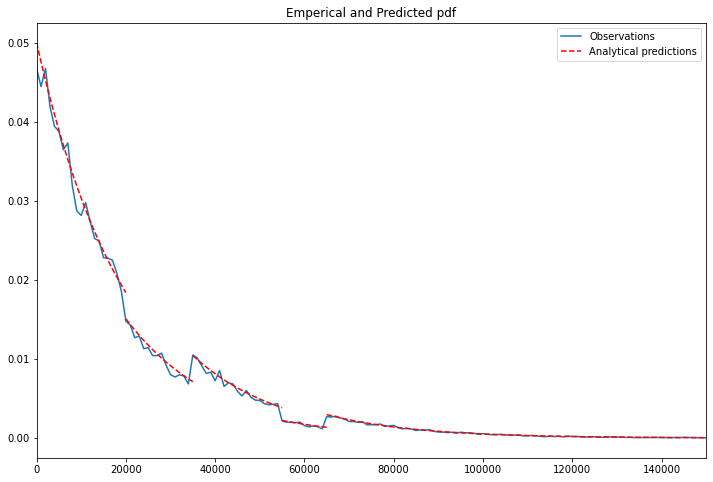

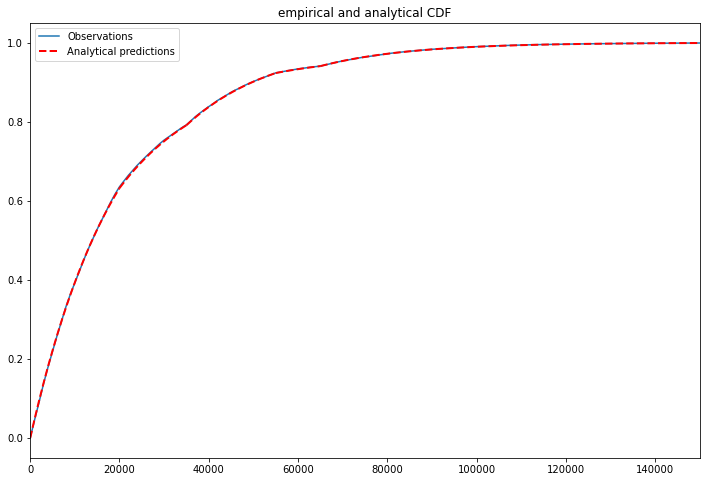

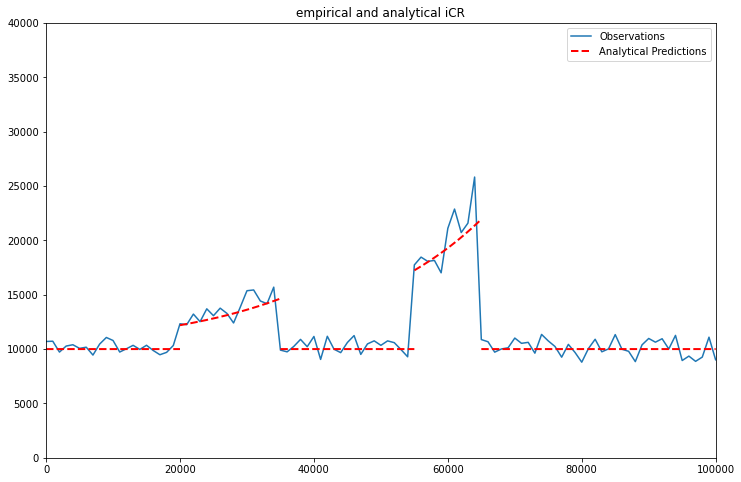

In [321]:

def f1(x,N):
    x = x/(2*N)
    f = np.exp(-x)
    return f*scaling

def F1(x,N):
    x = x/(2*N)
    F = 1-np.exp(-x)
    return F

def f2(x,mig_prop,T_1,N):
    x = (x)/(2*N)
    bigger_f1 = 1-F1(T_1,N)
    T_1 = T_1/(2*N)
    f = (mig_prop**2)*np.exp(-(x-T_1)) + ((1-mig_prop)**2)*1*np.exp(-(x-T_1)) 
    return bigger_f1*f*scaling 

# guess2 = 0

def F2(x,mig_prop,T_1,N):
    x = x/(2*N)
    bigger_f1 = 1-F1(T_1,N)
    T_1 = T_1 / (2*N)
    F = F1(T_1*2*N,N) + bigger_f1*(
        -(mig_prop**2)*np.exp(-(x-T_1)) - ((1-mig_prop)**2)*(np.exp(-(x-T_1)))
        -(-mig_prop**2 - (1-mig_prop)**2)
    )
    return F

def f3(x,mig_prop,T_1,T_2,N):
    x = x/(2*N)
    bigger_f2 = 1-F2(T_2,mig_prop,T_1,N)
    T_2 = T_2/(2*N)
    f = np.exp(-(x-T_2))
    return bigger_f2*f*scaling


def F3(x,mig_prop,T_1,T_2,N):
    x = x/(2*N)
    bigger_f2 = 1-F2(T_2,mig_prop,T_1,N)
    T_2 = T_2/(2*N)
    F = F2(T_2*(2*N),mig_prop,T_1,N) + bigger_f2*(
        (1-np.exp(-(x-T_2)))
    )
    return F

def f4(x,mig_prop1,mig_prop2,T_1,T_2,T_3,N):
    x = x/(2*N)
    bigger_f3 = 1-F3(T_3,mig_prop1,T_1,T_2,N)
    T_3 = T_3/(2*N)    
    f = (mig_prop2**2)*np.exp(-(x-T_3)) + ((1-mig_prop2)**2)*1*np.exp(-(x-T_3)) 
    return bigger_f3*f*scaling 

def F4(x,mig_prop1,mig_prop2,T_1,T_2,T_3,N):
    x = x/(2*N)
    bigger_f3 = 1-F3(T_3,mig_prop1,T_1,T_2,N)
    T_3 = T_3/(2*N)    
    F = F3(T_3*2*N,mig_prop1,T_1,T_2,N) + bigger_f3*(
        -(mig_prop2**2)*np.exp(-(x-T_3)) - ((1-mig_prop2)**2)*(np.exp(-(x-T_3)))
        -(-mig_prop2**2 - (1-mig_prop2)**2)
    )
    return F

def f5(x,mig_prop1,mig_prop2,T_1,T_2,T_3,T_4,N):
    x = x/(2*N)
    bigger_f4 = 1-F4(T_4,mig_prop1,mig_prop2,T_1,T_2,T_3,N)
    T_4 = T_4/(2*N)
    f = np.exp(-(x-T_4))
    return bigger_f4*f*scaling

def F5(x,mig_prop1,mig_prop2,T_1,T_2,T_3,T_4,N):
    x = x/(2*N)
    bigger_f4 = 1-F4(T_4,mig_prop1,mig_prop2,T_1,T_2,T_3,N)
    T_4 = T_4/(2*N)
    F = F4(T_4*(2*N),mig_prop1,mig_prop2,T_1,T_2,T_3,N) + bigger_f4*(
        (1-np.exp(-(x-T_4)))
    )
    return F
    

def iCR1(x,N):
    iCR = (1-F1(x,N))/(2*f1(x,N))
    return spacing*iCR

def iCR2(x,mig_prop,T_1,N):
    iCR = (1-F2(x,mig_prop,T_1,N))/(2*f2(x,mig_prop,T_1,N))
    return spacing*iCR

def iCR3(x,mig_prop,T_1,T_2,N):
    iCR = (1-F3(x,mig_prop,T_1,T_2,N))/(2*f3(x,mig_prop,T_1,T_2,N))
    return spacing*iCR

def iCR4(x,mig_prop1,mig_prop2,T_1,T_2,T_3,N):
    iCR = (1-F4(x,mig_prop1,mig_prop2,T_1,T_2,T_3,N))/(2*f4(x,mig_prop1,mig_prop2,T_1,T_2,T_3,N))
    return spacing*iCR

def iCR5(x,mig_prop1,mig_prop2,T_1,T_2,T_3,T_4,N):
    iCR = (1-F5(x,mig_prop1,mig_prop2,T_1,T_2,T_3,T_4,N))/(2*f5(x,mig_prop1,mig_prop2,T_1,T_2,T_3,T_4,N))
    return spacing*iCR

t1 = np.arange(0,T_1,1)
t2 = np.arange(T_1,T_2,1)
t3 = np.arange(T_2,T_3,1)
t4 = np.arange(T_3,T_4,1)
t5 = np.arange(T_4,max_time,1)

line_f_obs = plt.plot(time_intervals,f_obs7,label="Observations")
line_f1 = plt.plot(t1,f1(t1,N),label="Analytical predictions",color="red",linestyle="dashed")
line_f2 = plt.plot(t2,f2(t2,mig_prop1,T_1,N),color="red",linestyle="dashed")
line_f3 = plt.plot(t3,f3(t3,mig_prop1,T_1,T_2,N),color="red",linestyle="dashed")
line_f4 = plt.plot(t4,f4(t4,mig_prop1,mig_prop2,T_1,T_2,T_3,N),color="red",linestyle="dashed")
line_f5 = plt.plot(t5,f5(t5,mig_prop1,mig_prop2,T_1,T_2,T_3,T_4,N),color="red",linestyle="dashed")
# line_f3 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf')
plt.show()

line_F_obs = plt.plot(time_intervals,F_obs7,label="Observations")
line_F1 = plt.plot(t1,F1(t1,N),color = "red",label="Analytical predictions",linestyle="dashed",linewidth=2)
plt.plot(t2,F2(t2,mig_prop1,T_1,N),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t3,F3(t3,mig_prop1,T_1,T_2,N),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t4,F4(t4,mig_prop1,mig_prop2,T_1,T_2,T_3,N),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t5,F5(t5,mig_prop1,mig_prop2,T_1,T_2,T_3,T_4,N),color = "red",linestyle="dashed",linewidth=2)
plt.title('empirical and analytical CDF')
plt.legend()
plt.xlim(0,150000)
plt.show()

line_ICR_obs = plt.plot(time_intervals,iCR_obs7,label="Observations")
line_ICR1 = plt.plot(t1,iCR1(t1,N),color = "red",linestyle="dashed",linewidth=2,label="Analytical Predictions")
plt.plot(t2,iCR2(t2,mig_prop1,T_1,N),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t3,iCR3(t3,mig_prop1,T_1,T_2,N),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t4,iCR4(t4,mig_prop1,mig_prop2,T_1,T_2,T_3,N),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t5,iCR5(t5,mig_prop1,mig_prop2,T_1,T_2,T_3,T_4,N),color = "red",linestyle="dashed",linewidth=2)
plt.xlim(0,100000)
plt.ylim(0,40000)
plt.legend()
plt.title('empirical and analytical iCR')
plt.show()

Calculate recursively, still by hand 

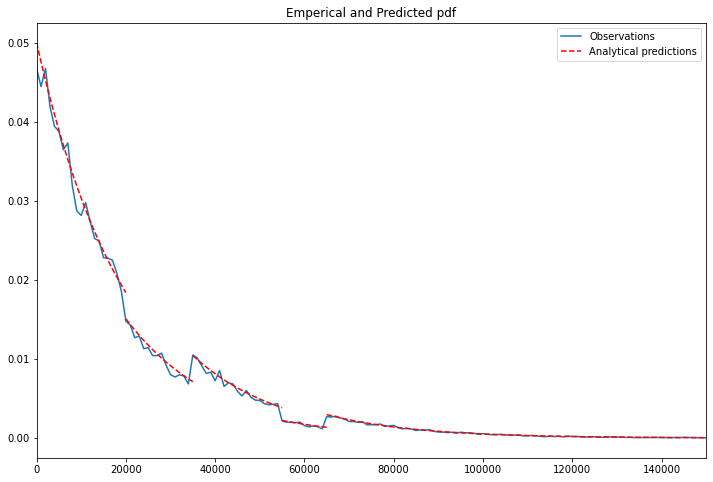

In [323]:
sigma1 = 1
sigma2 = 41/50
sigma3 = 1
sigma4 = 29/50
sigma5 = 1

def ef1(x,sigma1):
    x = x/20000
    f = 1 - sigma1 + sigma1*np.exp(-x)
    return f*scaling

def ef2(x,sigma1,sigma2,T_1):
    x = x/20000
    T_1 = T_1/20000
    f = (1 - sigma1 + sigma1*np.exp(-T_1))*(sigma2*np.exp(-(x-T_1)))
    return f*scaling

def ef3(x,sigma1,sigma2,simga3,T_1,T_2):
    x = x/20000
    T_1 = T_1/20000
    T_2 = T_2/20000
    f = (1 - sigma1 + sigma1*np.exp(-T_1))*(1 - sigma2 + sigma2*np.exp(-(T_2-T_1)))*(simga3*np.exp(-(x-T_2)))
    return f*scaling

def ef4(x,sigma1,sigma2,simga3,sigma4,T_1,T_2,T_3):
    x = x/20000
    T_1 = T_1/20000
    T_2 = T_2/20000
    T_3 = T_3/20000
    f = (1 - sigma1 + sigma1*np.exp(-T_1))*(1 - sigma2 + sigma2*np.exp(-(T_2-T_1)))*(
        1 - sigma3 + sigma3*np.exp(-(T_3-T_2)))*(sigma4*np.exp(-(x-T_3)))
    return f*scaling

def ef5(x,sigma1,sigma2,simga3,sigma4,sigma5,T_1,T_2,T_3,T_4):
    x = x/20000
    T_1 = T_1/20000
    T_2 = T_2/20000
    T_3 = T_3/20000
    T_4 = T_4/20000
    f = (1 - sigma1 + sigma1*np.exp(-T_1))*(1 - sigma2 + sigma2*np.exp(-(T_2-T_1)))*(
        1 - sigma3 + sigma3*np.exp(-(T_3-T_2)))*(1 - sigma4 + sigma4*np.exp(-(T_4-T_3)))*(sigma5*np.exp(-(x-T_4)))
    return f*scaling

line_f_obs = plt.plot(time_intervals,f_obs7,label="Observations")
line_f1 = plt.plot(t1,ef1(t1,sigma1),label="Analytical predictions",color="red",linestyle="dashed")
line_f2 = plt.plot(t2,ef2(t2,sigma1,sigma2,T_1),color="red",linestyle="dashed")
line_f3 = plt.plot(t3,ef3(t3,sigma1,sigma2,sigma3,T_1,T_2),color="red",linestyle="dashed")
line_f4 = plt.plot(t4,ef4(t4,sigma1,sigma2,sigma3,sigma4,T_1,T_2,T_3),color="red",linestyle="dashed")
line_f5 = plt.plot(t5,ef5(t5,sigma1,sigma2,sigma3,sigma4,sigma5,T_1,T_2,T_3,T_4),color="red",linestyle="dashed")

# line_f5 = plt.plot(t5,f5(t5,mig_prop1,mig_prop2,T_1,T_2,T_3,T_4,N),color="red",linestyle="dashed")
# # line_f3 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf')
plt.show()



Again calculate recursively 

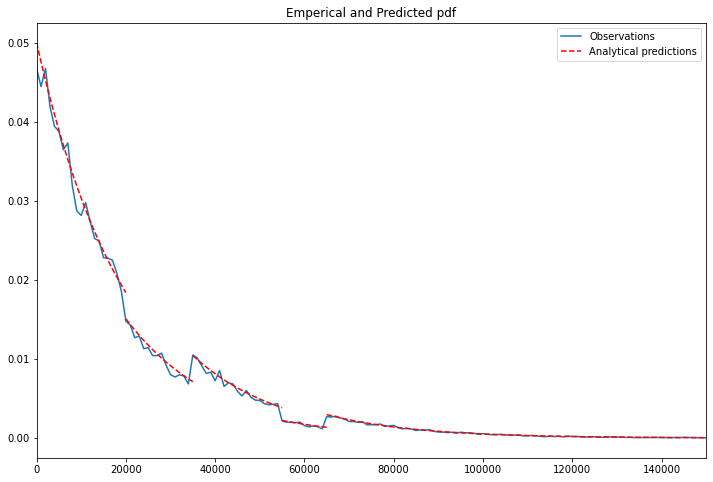

In [324]:
sigma1 = 1
sigma2 = 41/50
sigma3 = 1
sigma4 = 29/50
sigma5 = 1

def ef1(x,sigma1):
    x = x/20000
    f = 1 - sigma1 + sigma1*np.exp(-x)
    return f*scaling

def ef2(x,sigma1,sigma2,T_1):
    x = x/20000
    T_1 = T_1/20000
    f = (1 - sigma1 + sigma1*np.exp(-T_1))*(sigma2*np.exp(-(x-T_1)))
    return f*scaling

def ef3(x,sigma1,sigma2,simga3,T_1,T_2):
    x = x/20000
    T_1 = T_1/20000
    T_2 = T_2/20000
    f = (1 - sigma1 + sigma1*np.exp(-T_1))*(1 - sigma2 + sigma2*np.exp(-(T_2-T_1)))*(simga3*np.exp(-(x-T_2)))
    return f*scaling

def ef4(x,sigma1,sigma2,simga3,sigma4,T_1,T_2,T_3):
    x = x/20000
    T_1 = T_1/20000
    T_2 = T_2/20000
    T_3 = T_3/20000
    f = (1 - sigma1 + sigma1*np.exp(-T_1))*(1 - sigma2 + sigma2*np.exp(-(T_2-T_1)))*(
        1 - sigma3 + sigma3*np.exp(-(T_3-T_2)))*(sigma4*np.exp(-(x-T_3)))
    return f*scaling

def ef5(x,sigma1,sigma2,simga3,sigma4,sigma5,T_1,T_2,T_3,T_4):
    x = x/20000
    T_1 = T_1/20000
    T_2 = T_2/20000
    T_3 = T_3/20000
    T_4 = T_4/20000
    f = (1 - sigma1 + sigma1*np.exp(-T_1))*(1 - sigma2 + sigma2*np.exp(-(T_2-T_1)))*(
        1 - sigma3 + sigma3*np.exp(-(T_3-T_2)))*(1 - sigma4 + sigma4*np.exp(-(T_4-T_3)))*(
        1-sigma5 + sigma5*np.exp(-(x-T_4)))*sigma5
    return f*scaling

line_f_obs = plt.plot(time_intervals,f_obs7,label="Observations")
line_f1 = plt.plot(t1,ef1(t1,sigma1),label="Analytical predictions",color="red",linestyle="dashed")
line_f2 = plt.plot(t2,ef2(t2,sigma1,sigma2,T_1),color="red",linestyle="dashed")
line_f3 = plt.plot(t3,ef3(t3,sigma1,sigma2,sigma3,T_1,T_2),color="red",linestyle="dashed")
line_f4 = plt.plot(t4,ef4(t4,sigma1,sigma2,sigma3,sigma4,T_1,T_2,T_3),color="red",linestyle="dashed")
line_f5 = plt.plot(t5,ef5(t5,sigma1,sigma2,sigma3,sigma4,sigma5,T_1,T_2,T_3,T_4),color="red",linestyle="dashed")

# line_f5 = plt.plot(t5,f5(t5,mig_prop1,mig_prop2,T_1,T_2,T_3,T_4,N),color="red",linestyle="dashed")
# # line_f3 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf')
plt.show()


Now try with my function G, defined below

In [43]:
T_1 = 20000
T_2 = 35000
T_3 = 55000
T_4 = 65000

In [44]:
T_np[20]*20000

5520.1390247909985

In [45]:
# first define the tru lambda and gamma array

# T_1 = 20000
# T_2 = 35000
# T_3 = 55000
# T_4 = 65000
# These occur at indices 10, 15 (16), 20 (19) and 22 (21) where bracketed suggests an alternate which may be closer 

print('T_1, T_2, T_3 and T_4 are {} {} {} {}'.format(T_1,T_2,T_3,T_4))

lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

gamma_array[32:37] = 0.1
gamma_array[42:43] = 0.3
print(gamma_array)

print(T_np[32:38]*20000)
print(T_np[42:44]*20000)


T_1, T_2, T_3 and T_4 are 20000 35000 55000 65000
[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.1 0.1 0.1 0.1
 0.1 1.  1.  1.  1.  1.  0.3 1.  1.  1.  1.  1.  1.  1. ]
[19711.38176658 21916.99408938 24369.40421542 27096.22767576
 30128.17005154 33499.37273618]
[56931.97904675 63302.4038112 ]


In [46]:
t1_array = np.arange(0,T_1,1)
t2_array = np.arange(T_1,T_2,1)
t3_array = np.arange(T_2,T_3,1)
t4_array = np.arange(T_3,T_4,1)
t5_array = np.arange(T_4,max_time,1)

In [47]:
G1a = [(G(0,i/20000,gamma_array,lambda_array,T_np)) for i in t1_array]
G2a = [(G(0,i/20000,gamma_array,lambda_array,T_np)) for i in t2_array]
G3a = [(G(0,i/20000,gamma_array,lambda_array,T_np)) for i in t3_array]
G4a = [(G(0,i/20000,gamma_array,lambda_array,T_np)) for i in t4_array]
G5a = [(G(0,i/20000,gamma_array,lambda_array,T_np)) for i in t5_array]

In [326]:
G_obs7 = 1 - np.array(F_obs7)

In [49]:
# T_np[32:38]*20000
T_np[42:44]*20000

array([56931.97904675, 63302.4038112 ])

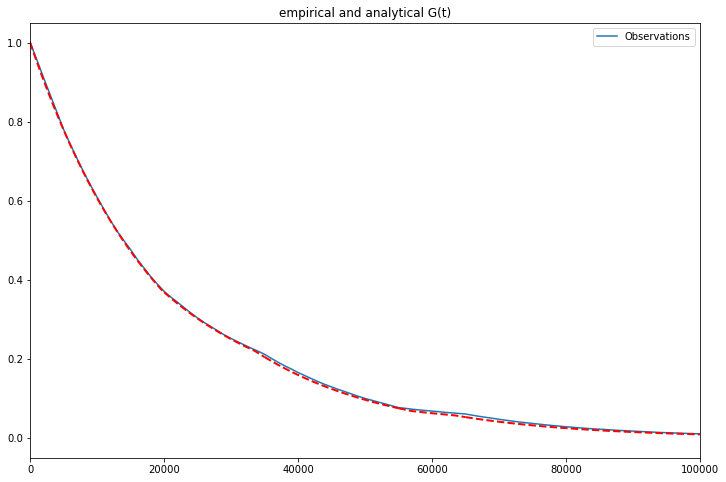

In [50]:
line_G_obs = plt.plot(time_intervals,G_obs7,label="Observations")
plt.plot(t1_array,G1a,color = "red",linestyle = "dashed",linewidth=2)
plt.plot(t2_array,G2a,color = "red",linestyle = "dashed",linewidth=2)
plt.plot(t3_array,G3a,color = "red",linestyle = "dashed",linewidth=2)
plt.plot(t4_array,G4a,color = "red",linestyle = "dashed",linewidth=2)
plt.plot(t5_array,G5a,color = "red",linestyle = "dashed",linewidth=2)
plt.title('empirical and analytical G(t)')
plt.legend()
plt.xlim(0,100000)
plt.show()



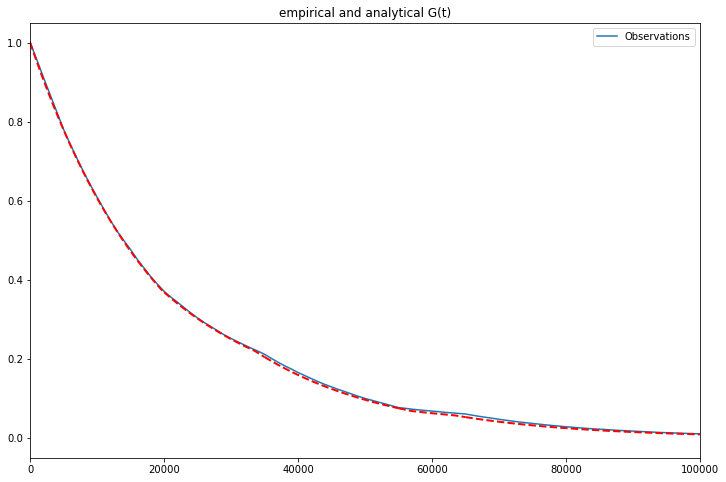

In [53]:
G1a = [(G_test(0,i/20000,gamma_array,lambda_array,T_np)) for i in t1_array]
G2a = [(G_test(0,i/20000,gamma_array,lambda_array,T_np)) for i in t2_array]
G3a = [(G_test(0,i/20000,gamma_array,lambda_array,T_np)) for i in t3_array]
G4a = [(G_test(0,i/20000,gamma_array,lambda_array,T_np)) for i in t4_array]
G5a = [(G_test(0,i/20000,gamma_array,lambda_array,T_np)) for i in t5_array]

line_G_obs = plt.plot(time_intervals,G_obs7,label="Observations")
plt.plot(t1_array,G1a,color = "red",linestyle = "dashed",linewidth=2)
plt.plot(t2_array,G2a,color = "red",linestyle = "dashed",linewidth=2)
plt.plot(t3_array,G3a,color = "red",linestyle = "dashed",linewidth=2)
plt.plot(t4_array,G4a,color = "red",linestyle = "dashed",linewidth=2)
plt.plot(t5_array,G5a,color = "red",linestyle = "dashed",linewidth=2)
plt.title('empirical and analytical G(t)')
plt.legend()
plt.xlim(0,100000)
plt.show()



### Try my function G_newnew

As written 20210208 ymd

In [330]:
G_theory_new_obs7 = [G_newnew(0,i/20000,gamma_array,lambda_array,T_np) for i in all_time]

T_1, T_2, T_3 and T_4 are 20000 35000 55000 65000
[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.1 0.1 0.1 0.1
 0.1 1.  1.  1.  1.  1.  0.3 1.  1.  1.  1.  1.  1.  1. ]
[19711.38176658 21916.99408938 24369.40421542 27096.22767576
 30128.17005154 33499.37273618]
[56931.97904675 63302.4038112 ]


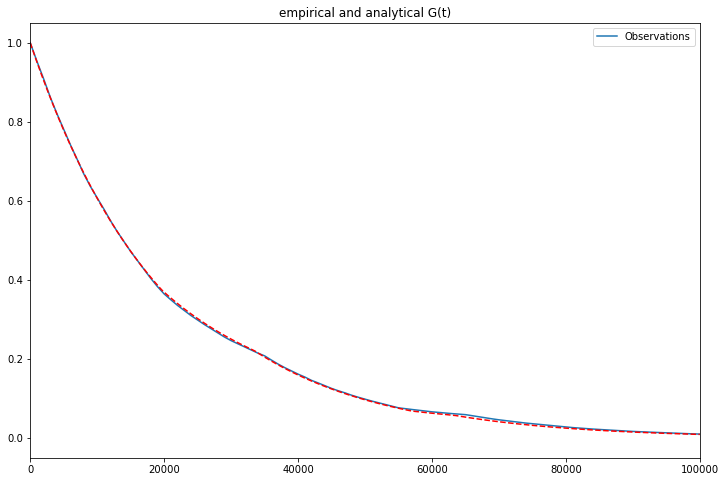

In [332]:
print('T_1, T_2, T_3 and T_4 are {} {} {} {}'.format(T_1,T_2,T_3,T_4))

lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

gamma_array[32:37] = 0.1
gamma_array[42:43] = 0.3
print(gamma_array)

print(T_np[32:38]*20000)
print(T_np[42:44]*20000)


line_G_obs = plt.plot(time_intervals,G_obs7,label="Observations")
plt.plot(all_time,G_theory_new_obs7,color="red",linestyle="dashed")
plt.title('empirical and analytical G(t)')
plt.legend()
plt.xlim(0,100000)
plt.show()


### Try my function G

In [221]:
a = 6
if (a>5) and (a<8 or a>6):
    print('hello!')

hello!


In [51]:
def G_test(t1,t2,gamma_array,lambda_array,T):
    """
    Assume t1 = ind1 =  0
    Then G(t) = no coalescing between 0 and t
    So if you want G between t1 and t2, you can do G = G(t2)/G(t1)
    For non 0 t1, can do 
    Takes as input t1 and t2 in scaled coalescent time
    t1, t2: can be boundaries or some number between a boundary
    Needs also gamma_array and lambda_array

    t1, t2: can be boundaries or some number between a boundary
    T: array of time intervals in coalescent time
    lambda_array: array of lambdas where lambda_i = N_0/pop_size_i
    gamma_array: array of population split fractions per time


    """
    
    def delta(i):
        delt = T[i+1] - T[i]
        return delt
    def lower_higher_intervals(t1,t2):
        # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        if ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2


    def G_main(t2,ind1,ind2):
        # main part of G (the recursive part; the product); see my notepad page TODO
        recursion = 1
        i = ind1 # ind1 should be 0
        while i < ind2:
            sigma = ( (1-gamma_array[i])**2 + gamma_array[i]**2 )
            if (gamma_array[i] == gamma_array[i+1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                c = i # c for 'change', the point at which gamma changes
                G_set = np.array([])
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c]))
                G_set = np.append(G_set,G_temp)
                recursion = recursion*G_temp
                i += 1
                while gamma_array[i] == gamma_array[i+1] and i < ind2:
                    G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                    G_temp = G_temp/np.prod(G_set)
                    G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                    recursion = recursion*G_temp
                    i += 1
#                 recursion = recursion*np.prod(G_set)
            elif (gamma_array[i] != gamma_array[i+1]) and (gamma_array[i] == gamma_array[i-1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                G_temp = G_temp/np.prod(G_set)
                G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                recursion = recursion*G_temp
                i += 1
            elif (gamma_array[i] != gamma_array[i-1]) and (gamma_array[i] == 0 or gamma_array[i] == 1):
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            else: 
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            
#         G_end
#         either t2 is in interval i with sigma_i == sigma_{i-1}
#         or t2 is in interval i where sigma_i != sigma_{i-1}
        if gamma_array[ind2] == gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: # if t2 is in an interval where there is the same gamma as the previous
            G_temp = 1 - sigma + sigma*np.exp(-lambda_array[ind2]*(t2-T[c])) # TODO this lambda needs to be summed
            G_temp = G_temp/np.prod(G_set) # don't bother adding this G_temp to G_set
            recursion = recursion*G_temp
        elif gamma_array[ind2] != gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: 
#             pdb.set_trace()
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] != gamma_array[ind2-1] and (gamma_array[ind2] == 1 or gamma_array[ind2] == 0):
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] == 1 or gamma_array[ind2] == 0:
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        else: 
            print('there has been an error!')
        return recursion
    
    def G_same(t1,t2,ind1):
        # if t1 and t2 are within the same interval
        G = 1 - ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) ) + ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) )*np.exp(-(lambda_array[ind1]*(t2-t1) ))
        return G

    ind1, ind2 = lower_higher_intervals(t1,t2) # get the intervals in which t1 and t2 are situated
    if ind1 == ind2: # if they are in the same interval
        G = G_same(t1,t2,ind1) 
    #elif ind1 == (ind2-1): # if they are one interval apart
    #    G = G_start(t1,ind1)*G_end(t2,ind2)
    else: # otherwise; there is some distance between them
        if t1 != 0:
            G = G_main(t2,0,ind2) / G_main(t1,0,ind1)
        elif t1 == 0:
            G = G_main(t2,ind1,ind2)
    #         G_end_ = G_end(t2,ind2)
            #*G_end_
    #         print('G_start_ is {}\nG_main_ is {}\nG_end_ is {}'.format(G_start_,G_main_,G_end_))
    return G
    # TODO try this on my distribution till coalesence thingtime  
  

In [19]:
def G(t1,t2,gamma_array,lambda_array,T):
    """
    Assume t1 = ind1 =  0
    Then G(t) = no coalescing between 0 and t
    So if you want G between t1 and t2, you can do G = G(t2)/G(t1)
    For non 0 t1, can do 
    Takes as input t1 and t2 in scaled coalescent time
    t1, t2: can be boundaries or some number between a boundary
    Needs also gamma_array and lambda_array

    t1, t2: can be boundaries or some number between a boundary
    T: array of time intervals in coalescent time
    lambda_array: array of lambdas where lambda_i = N_0/pop_size_i
    gamma_array: array of population split fractions per time


    """
    
    def lower_higher_intervals(t1,t2):
        # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        if ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2


    def G_main(t2,ind1,ind2):
        # main part of G (the recursive part; the product); see my notepad page TODO
        recursion = 1
        i = ind1 # ind1 should be 0
        while i < ind2:
            sigma = ( (1-gamma_array[i])**2 + gamma_array[i]**2 )
            if (gamma_array[i] == gamma_array[i+1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                c = i # c for 'change', the point at which gamma changes
                G_set = np.array([])
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c]))
                G_set = np.append(G_set,G_temp)
                recursion = recursion*G_temp
                i += 1
                while gamma_array[i] == gamma_array[i+1] and i < ind2:
                    G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                    G_temp = G_temp/np.prod(G_set)
                    G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                    recursion = recursion*G_temp
                    i += 1
#                 recursion = recursion*np.prod(G_set)
            elif (gamma_array[i] != gamma_array[i+1]) and (gamma_array[i] == gamma_array[i-1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                G_temp = G_temp/np.prod(G_set)
                G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                recursion = recursion*G_temp
                i += 1
            elif (gamma_array[i] != gamma_array[i-1]) and (gamma_array[i] == 0 or gamma_array[i] == 1):
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            else: 
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            
#         G_end
#         either t2 is in interval i with sigma_i == sigma_{i-1}
#         or t2 is in interval i where sigma_i != sigma_{i-1}
        if gamma_array[ind2] == gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: # if t2 is in an interval where there is the same gamma as the previous
            G_temp = 1 - sigma + sigma*np.exp(-lambda_array[ind2]*(t2-T[c])) # TODO this lambda needs to be summed
            G_temp = G_temp/np.prod(G_set) # don't bother adding this G_temp to G_set
            recursion = recursion*G_temp
        elif gamma_array[ind2] != gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: 
#             pdb.set_trace()
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] != gamma_array[ind2-1] and (gamma_array[ind2] == 1 or gamma_array[ind2] == 0):
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] == 1 or gamma_array[ind2] == 0:
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        else: 
            print('there has been an error!')
        return recursion
    
    def G_same(t1,t2,ind1):
        # if t1 and t2 are within the same interval
        G = 1 - ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) ) + ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) )*np.exp(-(lambda_array[ind1]*(t2-t1) ))
        return G

    ind1, ind2 = lower_higher_intervals(t1,t2) # get the intervals in which t1 and t2 are situated
    if ind1 == ind2: # if they are in the same interval
        G = G_same(t1,t2,ind1) 
    #elif ind1 == (ind2-1): # if they are one interval apart
    #    G = G_start(t1,ind1)*G_end(t2,ind2)
    else: # otherwise; there is some distance between them
        if t1 != 0:
            G = G_main(t2,0,ind2) / G_main(t1,0,ind1)
        elif t1 == 0:
            G = G_main(t2,ind1,ind2)
    #         G_end_ = G_end(t2,ind2)
            #*G_end_
    #         print('G_start_ is {}\nG_main_ is {}\nG_end_ is {}'.format(G_start_,G_main_,G_end_))
    return G
    # TODO try this on my distribution till coalesence thingtime  
    
def delta(int):
    # difference in each time interval
    delta_ = T[int+1] - T[int]
    return delta_

def lower_interval(x,T):
    # get the index of the next lower or equal time intervals for t1 and t2
    ind1 = np.argmin(abs(T - x)) # ind1 is index of lower time interval for time1
    if T[ind1] > x:
        ind1 = ind1 - 1
#     print('ind1 is {}; T[ind1] is {}; x is {}'.format(ind1,T[ind1],x))
    return ind1

def f_givenG(x,N):
    x = x / (2*N)
    G_ = G(0,x,gamma_array,lambda_array,T_np)
    ind1 = lower_interval(x,T_np)
#     print('ind1 is {}'.format(ind1))
    if ind1 == 50:
#         print('limiting ind1')
        ind1 = ind1 -1
        sigma = (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2)
    else: 
        sigma = (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2)
    f = G_*lambda_array[ind1]*sigma
    return f
    
def G_copyold(t1,t2,gamma_array,lambda_array,T):
    """
    Assume t1 = ind1 =  0
    Then G(t) = no coalescing between 0 and t
    So if you want G between t1 and t2, you can do G = G(t2)/G(t1)
    For non 0 t1, can do 
    Takes as input t1 and t2 in scaled coalescent time
    t1, t2: can be boundaries or some number between a boundary
    Needs also gamma_array and lambda_array

    t1, t2: can be boundaries or some number between a boundary
    T: array of time intervals in coalescent time
    lambda_array: array of lambdas where lambda_i = N_0/pop_size_i
    gamma_array: array of population split fractions per time


    """
    
    def lower_higher_intervals(t1,t2):
        # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        if ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2


    def G_main(t2,ind1,ind2):
        # main part of G (the recursive part; the product); see my notepad page TODO
        recursion = 1
        i = ind1 # ind1 should be 0
        while i < ind2:
            sigma = ( (1-gamma_array[i])**2 + gamma_array[i]**2 )
            if (gamma_array[i] == gamma_array[i+1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                c = i # c for 'change', the point at which gamma changes
                G_set = np.array([])
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c]))
                G_set = np.append(G_set,G_temp)
                recursion = recursion*G_temp
                i += 1
                while gamma_array[i] == gamma_array[i+1] and i < ind2:
                    G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                    G_temp = G_temp/np.prod(G_set)
                    G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                    recursion = recursion*G_temp
                    i += 1
#                 recursion = recursion*np.prod(G_set)
            elif (gamma_array[i] != gamma_array[i+1]) and (gamma_array[i] == gamma_array[i-1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                G_temp = G_temp/np.prod(G_set)
                G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                recursion = recursion*G_temp
                i += 1
            elif (gamma_array[i] != gamma_array[i-1]) and (gamma_array[i] == 0 or gamma_array[i] == 1):
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            else: 
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            
#         G_end
#         either t2 is in interval i with sigma_i == sigma_{i-1}
#         or t2 is in interval i where sigma_i != sigma_{i-1}
        if gamma_array[ind2] == gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: # if t2 is in an interval where there is the same gamma as the previous
            G_temp = 1 - sigma + sigma*np.exp(-lambda_array[ind2]*(t2-T[c])) # TODO this lambda needs to be summed
            G_temp = G_temp/np.prod(G_set) # don't bother adding this G_temp to G_set
            recursion = recursion*G_temp
        elif gamma_array[ind2] != gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: 
#             pdb.set_trace()
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] != gamma_array[ind2-1] and (gamma_array[ind2] == 1 or gamma_array[ind2] == 0):
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] == 1 or gamma_array[ind2] == 0:
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        else: 
            print('there has been an error!')
        return recursion
    
    def G_same(t1,t2,ind1):
        # if t1 and t2 are within the same interval
        G = 1 - ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) ) + ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) )*np.exp(-(lambda_array[ind1]*(t2-t1) ))
        return G

    ind1, ind2 = lower_higher_intervals(t1,t2) # get the intervals in which t1 and t2 are situated
    if ind1 == ind2: # if they are in the same interval
        G = G_same(t1,t2,ind1) 
    #elif ind1 == (ind2-1): # if they are one interval apart
    #    G = G_start(t1,ind1)*G_end(t2,ind2)
    else: # otherwise; there is some distance between them
        if t1 != 0:
            G = G_main(t2,0,ind2) / G_main(t1,0,ind1)
        elif t1 == 0:
            G = G_main(t2,ind1,ind2)
    #         G_end_ = G_end(t2,ind2)
            #*G_end_
    #         print('G_start_ is {}\nG_main_ is {}\nG_end_ is {}'.format(G_start_,G_main_,G_end_))
    return G
    # TODO try this on my distribution till coalesence thingtime
    
    
def G_copy(t1,t2,gamma_array,lambda_array,T):
    """
    Assume t1 = ind1 =  0
    Then G(t) = no coalescing between 0 and t
    So if you want G between t1 and t2, you can do G = G(t2)/G(t1)
    For non 0 t1, can do 
    Takes as input t1 and t2 in scaled coalescent time
    t1, t2: can be boundaries or some number between a boundary
    Needs also gamma_array and lambda_array

    t1, t2: can be boundaries or some number between a boundary
    T: array of time intervals in coalescent time
    lambda_array: array of lambdas where lambda_i = N_0/pop_size_i
    gamma_array: array of population split fractions per time


    """
    
    def lower_higher_intervals(t1,t2):
        # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        if ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2


    def G_main(t2,ind1,ind2):
        # main part of G (the recursive part; the product); see my notepad page TODO
        recursion = 1
        i = ind1 # ind1 should be 0
        while i < ind2:
            sigma = ( (1-gamma_array[i])**2 + gamma_array[i]**2 )
            if (gamma_array[i] == gamma_array[i+1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                c = i # c for 'change', the point at which gamma changes
                G_set = np.array([])
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c]))
                G_set = np.append(G_set,G_temp)
                recursion = recursion*G_temp
                i += 1
                while gamma_array[i] == gamma_array[i+1] and i < ind2:
                    G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                    G_temp = G_temp/np.prod(G_set)
                    G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                    recursion = recursion*G_temp
                    i += 1
#                 recursion = recursion*np.prod(G_set)
            elif (gamma_array[i] != gamma_array[i+1]) and (gamma_array[i] == gamma_array[i-1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                G_temp = G_temp/np.prod(G_set)
                G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                recursion = recursion*G_temp
                i += 1
            else: 
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            
#         G_end
#         either t2 is in interval i with sigma_i == sigma_{i-1}
#         or t2 is in interval i where sigma_i != sigma_{i-1}
        if gamma_array[ind2] == gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: # if t2 is in an interval where there is the same gamma as the previous
            G_temp = 1 - sigma + sigma*np.exp(-lambda_array[ind2]*(t2-T[c])) # TODO this lambda needs to be summed
            G_temp = G_temp/np.prod(G_set) # don't bother adding this G_temp to G_set
            recursion = recursion*G_temp
        elif gamma_array[ind2] != gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: 
#             pdb.set_trace()
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] == 1 or gamma_array[ind2] == 0:
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        else: 
            print('there has been an error!')
        return recursion
    
    def G_same(t1,t2,ind1):
        # if t1 and t2 are within the same interval
        G = 1 - ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) ) + ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) )*np.exp(-(lambda_array[ind1]*(t2-t1) ))
        return G

    ind1, ind2 = lower_higher_intervals(t1,t2) # get the intervals in which t1 and t2 are situated
    if ind1 == ind2: # if they are in the same interval
        G = G_same(t1,t2,ind1) 
    #elif ind1 == (ind2-1): # if they are one interval apart
    #    G = G_start(t1,ind1)*G_end(t2,ind2)
    else: # otherwise; there is some distance between them
        G_main_ = G_main(t2,ind1,ind2)
#         G_end_ = G_end(t2,ind2)
        G = G_main_ #*G_end_
#         print('G_start_ is {}\nG_main_ is {}\nG_end_ is {}'.format(G_start_,G_main_,G_end_))
    return G
    # TODO try this on my distribution till coalesence thingtime
    

In [113]:
# scaled_time_intervals 

mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 20
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0

# print(f'T_np is {T_np}\n\n')
# print(f'T_scaled_np is {T_scaled_np}')

In [542]:
lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array = [0 for i in range(0,N_T)]

G(0,1,gamma_array,lambda_array,T_np)


# gamma_array = [0 for i in range(0,N_T)]
# print('\n\n\ngamma is 0')
# G_copy(0,3,gamma_array,lambda_array,T_np)


0.36787944117144245

## Testing my G function on a different history

In [11]:
T_np[35]*20000

27096.22767576434

In [12]:
N = 1e+04
seq_length = 150e+06
mig_prop = 0.3
T_1 = 5520
T_2 = 27096



print("Running simulation")
sim7a = split(N,mig_prop,T_1,T_2,seq_length)
print("Simulation finished")


Running simulation
N is 10000.0
mig_prop is 0.3
t_1 is 5520 and t_2 is 27096
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 5520.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 5520.0
   - Mass migration: Lineages moved with probability 0.3 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forwards in time)
Epoch: 5520.0 -- 27096.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 27096.0
   - Mass migration: Lineages moved with probability 1 backwards in time with source 1

In [13]:
f_obs7a = get_counts_freq(sim7a,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs7a = [sum(f_obs7a[0:t]) for t in range(len(f_obs7a))] # this returns the CDF of T2 ( F_T2(t) )
iCR_obs7a = [spacing*(1-F_obs7a[i])/(2*f_obs7a[i]) for i in range(len(f_obs7a)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)

/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
G_obs7a = 1 - np.array(F_obs7a)

In [19]:
T_np[20:36]*2*N_0

array([ 5520.13902479,  6137.81701413,  6824.61030959,  7588.2525938 ,
        8437.34291267,  9381.44250549, 10431.18246999, 11598.38347445,
       12896.18886521, 14339.21266816, 15943.70415104, 17727.73079936,
       19711.38176658, 21916.99408938, 24369.40421542, 27096.22767576])

In [353]:
# T_np[32] #for T_1
# T_np[37] # for T_2
# T_np[42] # for T_3
# T_np[43] # for T_4

lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

gamma_array[20:35] = 0.3

In [118]:
gamma_array

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

In [112]:
T_1 = 5520
T_2 = 27096
T_1a = (T_1 + T_2)*0.4


t1_array = np.arange(0,T_1,1)
t2_array = np.arange(T_1,T_2,1)
t3_array = np.arange(T_2,max_time,1)
t2a_array = np.arange(T_1,T_1a,1)
t2b_array = np.arange(T_1a,T_2,1)

In [20]:
G1 = [(G(0,i/20000,gamma_array,lambda_array,T_np)) for i in t1_array]
G2 = [(G(0,i/20000,gamma_array,lambda_array,T_np)) for i in t2_array]
G3 = [(G(0,i/20000,gamma_array,lambda_array,T_np)) for i in t3_array]

The functions G1_new, G2_new, G2a_new, G2b_new, G3_new solve the problem that I had been having. Particularly, G2a_new and G2b_new are illustrative.

They (G2a_new and G2b_new) show that when you are iterating through time intervals where many have the same sigma value, you cannot simply iteratively run (1-sigma_i + sigma_i*exp(-lambda_i*(x_{i+1} - x_{i})). Instead, you must do it per interval....See the functions for an explanation

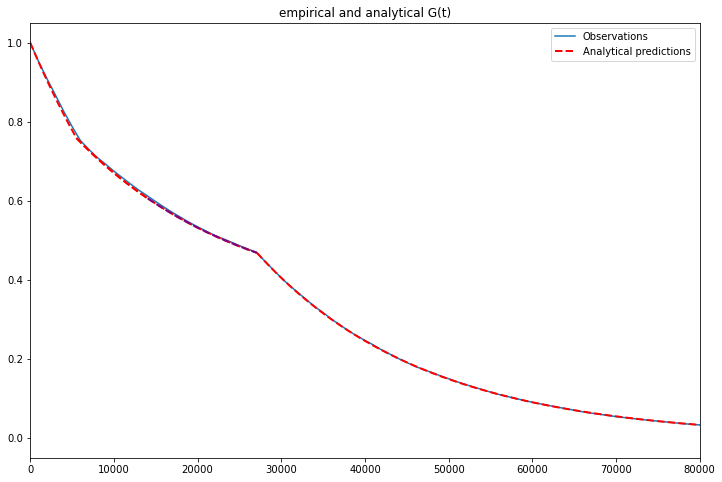

hello!


In [106]:
sigma1 = 1
sigma2 = 0.58
sigma3 = 1

T_1a = (T_1 + T_2)*0.43
T_1b = (T_1 + T_2)*0.67

t1_array = np.arange(0,T_1,1)
t2_array = np.arange(T_1,T_2,1)
t3_array = np.arange(T_2,max_time,1)
t2a_array = np.arange(T_1,T_1a,1)
t2b_array = np.arange(T_1a,T_2,1)

# these work well
def G1_new(x,sigma):
    x = x/20000
    G = 1 - sigma + sigma*np.exp(-x)
    return G

def G2_new(x,sigma1,sigma2,T_1):
    x = x/20000
    G1 = G1_new(T_1,sigma1)
    G2 = 1 - sigma2 + sigma2*np.exp(-(x-T_1/20000))
    G = G1*G2
    return G

def G2a_new(x,sigma1,sigma2,T_1):
    x = x/20000
    G1 = G1_new(T_1,sigma1)
    G2 = 1 - sigma2*(1- np.exp(-(x-T_1/20000)))
    G = G1*G2
    return G

def G2b_new(x,sigma1,sigma2,T_1,T_1a):
    x = x/20000
    G1 = G1_new(T_1,sigma1)
    G2a = G2a_new(T_1a,sigma1,sigma2,T_1)
    T_1 = T_1/20000
    T_1a = T_1a/20000
#     print(f'G2a is {G2a}')

# method one. This works
    G2b = (1 - sigma2 + sigma2*np.exp(-(x-T_1))) /(1 - sigma2 + sigma2*np.exp(-(T_1a-T_1))) # this works!!!!  (with line below as G = G2a*G2b)
    G = G2a*G2b
    
#method two. This also works
#     G2b = ((1 - sigma2 + sigma2*np.exp(-(x-T_1))) /(1 - sigma2 + sigma2*np.exp(-(T_1a-T_1))) )*((1 - sigma2 + sigma2*np.exp(-(T_1a-T_1)))) 
#     G = G2b * G1


    return G
    
def G3_new(x,sigma1,sigma2,sigma3,T_1,T_2):
    x = x/20000
#     G1 = G1_new(T_1,sigma1)
    G2 = G2_new(T_2,sigma1,sigma2,T_1)
    G3 =  1 - sigma3 + sigma3*np.exp(-(x-T_2/20000))
    G = G2*G3
    return G


line_F_obs = plt.plot(time_intervals,G_obs7a,label="Observations")
line_F1 = plt.plot(t1_array,G1_new(t1_array,sigma1),color = "red",linestyle = "dashed",label="Analytical predictions",linewidth=2)
plt.plot(t2_array,G2_new(t2_array,sigma1,sigma2,T_1),color = "red",linestyle = "dashed",linewidth=2)
plt.plot(t2a_array,G2a_new(t2a_array,sigma1,sigma2,T_1),color = "red",linestyle = "dashed",linewidth=2)
plt.plot(t2b_array,G2b_new(t2b_array,sigma1,sigma2,T_1,T_1a),linestyle = "dashed",color = "purple",linewidth=2)
plt.plot(t3_array,G3_new(t3_array,sigma1,sigma2,sigma3,T_1,T_2),linestyle = "dashed",color = "red",linewidth=2)

# plt.plot(t1_array,G1,color = "red",linestyle = "dashed",linewidth=2)
# plt.plot(t2_array,G2,color = "red",linestyle = "dashed",linewidth=2)
# plt.plot(t3_array,G3,color = "red",linestyle = "dashed",linewidth=2)



plt.title('empirical and analytical G(t)')
plt.legend()
plt.xlim(0,80000)
plt.show()
print('hello!')

In [62]:
T_1
T_1a = (T_1 + T_2)*0.43
T_1b = (T_1 + T_2)*0.67
t = T_2 - 1500

print('T_1 is {} and T_2 is {}\nT_1a is {} and T_1b is {} and t is {}'.format(T_1,T_2,T_1a,T_1b,t))

# prob of not coalescing between 0 and T_1a
probT1a = G2_new(T_1a,sigma1,sigma2,T_1)

# prob of not coalescing between 0 and T_1b
probT1b = G2_new(T_1b,sigma1,sigma2,T_1)

# prob of not coalescing between T_1a and T_1b
probT1ab = probT1b/probT1a

print('\n\nprobT1a is {}\nprobT1b is {}\nprob T1ab is {}'.format(probT1a,probT1b,probT1ab))
test_prob = (1-sigma2+sigma2*np.exp(-(T_1b-T_1)/20000))/(1-sigma2+sigma2*np.exp(-(T_1a-T_1)/20000))
print('test_prob is {}'.format(test_prob))


prob_t = G2_new(t,sigma1,sigma2,T_1)
prob_T1b = G2_new(T_1b,sigma1,sigma2,T_1)
print('\n\nprob_t is {}\nprob_T1b is {}'.format(prob_t,prob_T1b))
prob_t_T1b = prob_t/prob_T1b
test_prob2 = (1-sigma2+sigma2*(np.exp(-(t-T_1)/20000)))/(1-sigma2+sigma2*(np.exp(-(T_1b-T_1)/20000)))
print('prob_t_T1b is {} and test_prob2 is {}'.format(prob_t_T1b,test_prob2))

t2 = 

T_1 is 5520 and T_2 is 27096
T_1a is 14024.88 and T_1b is 21852.72 and t is 25596


probT1a is 0.6063628336582173
probT1b is 0.5131936394995247
prob T1ab is 0.846347452404696
test_prob is 0.846347452404696


prob_t is 0.4799953207348742
prob_T1b is 0.5131936394995247
prob_t_T1b is 0.9353103464083732 and test_prob2 is 0.9353103464083732


### Try new function

As of 20210207 ymd this function (G_new) is looking pretty good, not perfect but good and much simpler than the old function! I suggest we work with this in the future; may be easier to derive G' and J etc. 

As of 20210208 ymd I think this function (G_newnew) is looking very good. I will use this in future. 

In [302]:
def psi_finder(ind,gamma_array):
    # find the last change in gamma: m is current location of iration
    i = 1
    psi = None
    while psi == None:
        if gamma_array[ind] == 1:
            psi = ind
        elif gamma_array[ind] == gamma_array[ind-i]:
            i += 1
        elif gamma_array[ind] != gamma_array[ind-i]:
            psi = ind-i+1
        else:
            print('There has been an error in psi finder!')
    return psi

def G_new(t1,t2,gamma_array,lambda_array,T):
    def lower_higher_intervals(t1,t2):
    # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
    #         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        elif ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
    #         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2

    def G_upper(ind,t):
        sigma = (1-gamma_array[ind])**2 + gamma_array[ind]**2
        psi = psi_finder(ind,gamma_array)
        numerator = 1 - sigma + sigma*np.exp(-(t-T[psi]))
        denominator = 1 - sigma + sigma*np.exp(-(T[ind]- T[psi]))
        G = numerator/denominator
        return G
    def G_lower(ind,t):
        sigma = (1-gamma_array[ind])**2 + gamma_array[ind]**2
        psi = psi_finder(ind,gamma_array)
        whole_int = 1 - sigma + sigma*np.exp(-(T[ind+1]-T[psi]))/(1 - sigma + sigma*np.exp(-(T[ind]-T[psi]))) # get prob of whole interval
        partial_int = 1 - sigma + sigma*np.exp(-(t-T[psi]))/(1 - sigma + sigma*np.exp(-(T[ind]-T[psi]))) # get prob of start of int to t
        G = whole_int/partial_int # get only the latter bit of int (t to ind+1)
        return G
    def G_main(ind1,ind2):
        recursion = 1
        G_set = np.array([])
        psi = psi_finder(ind1,gamma_array)
        sigma = (1-gamma_array[ind1])**2 + gamma_array[ind1]**2
        G_temp = (1 -sigma + sigma*np.exp(-(T[ind1+1]-T[psi])))/(1 -sigma + sigma*np.exp(-(T[ind1]-T[psi])))
        recursion = recursion*G_temp
        G_set = np.append(G_set,G_temp)
        for i in range(ind1+1,ind2):
            psi = psi_finder(i,gamma_array)
            sigma = (1-gamma_array[i])**2 + gamma_array[i]**2
            G_temp = (1 -sigma + sigma*np.exp(-(T[i+1]-T[psi])))/(1 -sigma + sigma*np.exp(-(T[i]-T[psi])))
            recursion = recursion*G_temp
            G_set = np.append(G_set,G_temp)
        G = np.prod(G_set)
        return G
    
    ind1, ind2 = lower_higher_intervals(t1,t2)
    G_upper = G_upper(ind2, t2)
    if t1 > T[ind1]:
        G_lower = G_lower(ind1,t1)
    else: 
        G_lower = 1
    if ind1!=ind2:
        G_main = G_main(ind1,ind2)
    elif ind1==ind2:
        G_main=1
    G = G_lower*G_main*G_upper
    return G

def G_newnew(t1,t2,gamma_array,lambda_array,T):
    # assume t1 = 0 and work out G(t1,t2) by doing G(t1,t2)=G(0,t2)/G(0,t1)
    
    def lower_higher_intervals(t1,t2):
    # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
    #         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        elif ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
    #         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2

    def G_upper(ind,t):
        sigma = (1-gamma_array[ind])**2 + gamma_array[ind]**2
        psi = psi_finder(ind,gamma_array)
        numerator = 1 - sigma + sigma*np.exp(-(t-T[psi]))
        denominator = 1 - sigma + sigma*np.exp(-(T[ind]- T[psi]))
        G = numerator/denominator
        return G
    def G_main(ind1,ind2):
        recursion = 1
        G_set = np.array([])
        psi = psi_finder(ind1,gamma_array)
        sigma = (1-gamma_array[ind1])**2 + gamma_array[ind1]**2
        G_temp = (1 -sigma + sigma*np.exp(-(T[ind1+1]-T[psi])))/(1 -sigma + sigma*np.exp(-(T[ind1]-T[psi])))
        recursion = recursion*G_temp
        G_set = np.append(G_set,G_temp)
        for i in range(ind1+1,ind2):
            psi = psi_finder(i,gamma_array)
            sigma = (1-gamma_array[i])**2 + gamma_array[i]**2
            G_temp = (1 -sigma + sigma*np.exp(-(T[i+1]-T[psi])))/(1 -sigma + sigma*np.exp(-(T[i]-T[psi])))
            recursion = recursion*G_temp
            G_set = np.append(G_set,G_temp)
        G = np.prod(G_set)
        return G
    
    
    ind1, ind2 = lower_higher_intervals(t1,t2)
    
    G_upper_t2 = G_upper(ind2, t2)
    if ind2>0:
        G_main_t2 = G_main(0,ind2)
    elif ind2==0:
        G_main_t2=1
    G_t2 = G_main_t2*G_upper_t2
        
    if ind1==t1==0:
        G_t1 = 1
    else:
        G_upper_t1 = G_upper(ind1,t1)
        if ind1>0:
            G_main_t1 = G_main(0,ind1)
        elif ind1==0:
            G_main_t1 = 1
        G_t1 = G_main_t1*G_upper_t1
    
    G = G_t2/G_t1

    return G

        
    
    

In [284]:
G_theory = [G_new(0,i/20000,gamma_array,lambda_array,T_np) for i in all_time]

In [314]:
G_theory_new = [G_newnew(0,i/20000,gamma_array,lambda_array,T_np) for i in all_time]

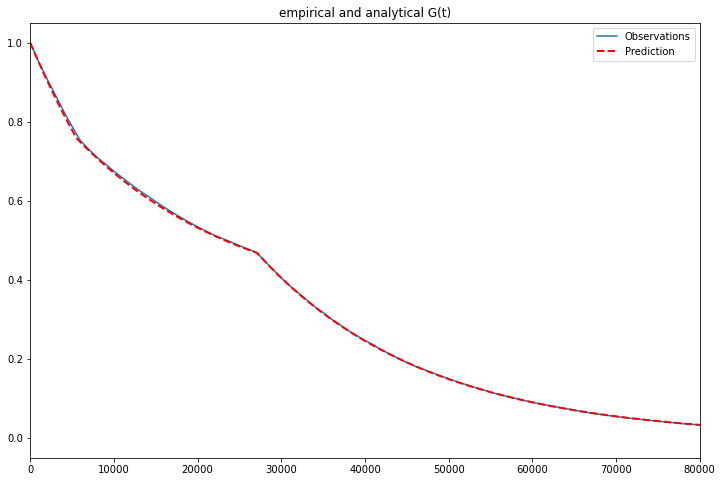

In [334]:
sigma1 = 1
sigma2 = 0.58
sigma3 = 1

T_1a = (T_1 + T_2)*0.43
T_1b = (T_1 + T_2)*0.67

t1_array = np.arange(0,T_1,1)
t2_array = np.arange(T_1,T_2,1)
t3_array = np.arange(T_2,max_time,1)
t2a_array = np.arange(T_1,T_1a,1)
t2b_array = np.arange(T_1a,T_2,1)
all_time = np.arange(0,max_time,1)


line_F_obs = plt.plot(time_intervals,G_obs7a,label="Observations")
# plt.plot(all_time,G_theory,color = "purple",linestyle = "dashed",linewidth=4)
plt.plot(all_time,G_theory_new,color = "red",label="Prediction",linestyle = "dashed",linewidth=2)


# plt.plot(t1_array,G1,color = "red",linestyle = "dashed",linewidth=2)
# plt.plot(t2_array,G2,color = "red",linestyle = "dashed",linewidth=2)
# plt.plot(t3_array,G3,color = "red",linestyle = "dashed",linewidth=2)



plt.title('empirical and analytical G(t)')
plt.legend()
plt.xlim(0,80000)
plt.show()


Looking at the above I'm quite satisfied that G_newnew is working well. 

Now I test for non zero t1 and ind1 below:

In [313]:
a = 1.713995
b = 3.77199
G = G_newnew(a,b,gamma_array,lambda_array,T_np)
G_t2 = G_newnew(0,b,gamma_array,lambda_array,T_np)
G_t1 = G_newnew(0,a,gamma_array,lambda_array,T_np)
G_ = G_t2/G_t1
equal = (G == G_)
print('G is {}; G_ is {}; G==G_ is {}'.format(G,G_,equal))

a = 0.3396
b = 5.23498
G = G_newnew(a,b,gamma_array,lambda_array,T_np)
G_t2 = G_newnew(0,b,gamma_array,lambda_array,T_np)
G_t1 = G_newnew(0,a,gamma_array,lambda_array,T_np)
G_ = G_t2/G_t1
equal = (G == G_)
print('G is {}; G_ is {}; G==G_ is {}'.format(G,G_,equal))

a = 2.345
b = 2.347
G = G_newnew(a,b,gamma_array,lambda_array,T_np)
G_t2 = G_newnew(0,b,gamma_array,lambda_array,T_np)
G_t1 = G_newnew(0,a,gamma_array,lambda_array,T_np)
G_ = G_t2/G_t1
equal = (G == G_)
print('G is {}; G_ is {}; G==G_ is {}'.format(G,G_,equal))



G is 0.12770977145983473; G_ is 0.12770977145983473; G==G_ is True
G is 0.013215838298454442; G_ is 0.013215838298454442; G==G_ is True
G is 0.9980019986673334; G_ is 0.9980019986673334; G==G_ is True


In [357]:
(1-0.2)**2 + 0.2**2

0.6800000000000002

I am satisfied that this is working well. 

In [343]:
scaling

0.05

In [364]:
(1-0.3) + 0.3

1.0

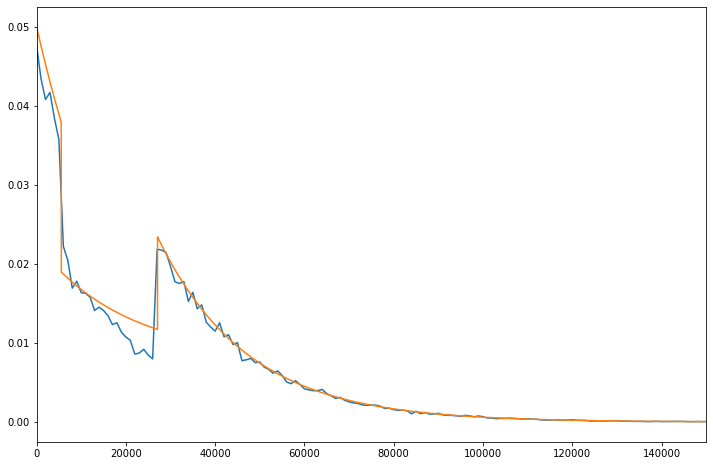

In [363]:

def f_theory_func(x,gamma_array,lambda_array,T_np):
    if x<=27096 and x>=5520:
        sigma = 0.5
    else:
        sigma = 1
    f = G_newnew(0,x/20000,gamma_array,lambda_array,T_np)*sigma
    return f*scaling

f_theory = [f_theory_func(i,gamma_array,lambda_array,T_np) for i in all_time]
line_f_obs = plt.plot(time_intervals,f_obs7a,label="Observations")
# G_theory_new = [G_newnew(0,i/20000,gamma_array,lambda_array,T_np) for i in all_time]
plt.xlim(0,150000)
plt.plot(all_time,f_theory)

## Population has two bouts of fixed migration

Create a history that has two periods of migration, of differing amounts

In [39]:
def structure_samedeme_double(mig_rate1,mig_rate2,N,T_1,T_2,T_3,T_4,seq_length):
    N_A0 = N
    N_B0 =  N
    m1 = mig_rate1
    m2 = mig_rate2
    
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A0, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N_B0, growth_rate=0)
    ]
    migration_matrix = [[0,0],[0,0]]
    demographic_events = [
        msprime.MigrationRateChange(time = T_1,rate = m1, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_1,rate = m1, matrix_index=(1,0)),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(1,0)),        
        msprime.MassMigration(time=T_2, source =1, destination =0, proportion = 1),
        msprime.MigrationRateChange(time = T_3,rate = m2, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_3,rate = m2, matrix_index=(1,0)),
        msprime.MigrationRateChange(time = T_4,rate = 0, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_4,rate = 0, matrix_index=(1,0)),        
        msprime.MassMigration(time=T_4, source =1, destination =0, proportion = 1)
    ]
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,migration_matrix=migration_matrix,
        demographic_events=demographic_events)

    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,mutation_rate=2e-08)
    return sim


In [7]:
# run simulation
seq_length = 150e+06
T_1 = 20000
T_2 = 30000
T_3 = 45000
T_4 = 67000
mig_rate1 = 5e-05
mig_rate2 = 8e-06
N = 10000 # diploid size

print("Running simulation")
sim8 = structure_samedeme_double(mig_rate1,mig_rate2,N,T_1,T_2,T_3,T_4,seq_length)
print("Simulation finished")

Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 20000.0
   - Migration rate change for (0, 1) to 5e-05
   - Migration rate change for (1, 0) to 5e-05
Epoch: 20000.0 -- 30000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0      5e-05  
1 |  1e+04    1e+04               0 |   5e-05      0    

Events @ generation 30000.0
   - Migration rate change for (0, 1) to 0
   - Migration rate change for (1, 0) to 0
   - Mass migration: Lineages moved with probability 1 backwards in time with source 1 & dest 0
                     (equivalent to migration from 0 to 1 forward

In [11]:
f_obs8 = get_counts_freq(sim8,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs8 = [sum(f_obs8[0:t]) for t in range(len(f_obs8))] # this returns the CDF of T2 ( F_T2(t) )
iCR_obs8 = [spacing*(1-F_obs8[i])/(2*f_obs8[i]) for i in range(len(f_obs8)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)

/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


M1, gamma1, theta, discriminant1, alpha1, beta1, a1, c1 are [2.0, 2.0, 0.0008, 17.0, 4.561552812808831, 0.4384471871911697, 0.6212678125181664, -0.4850712500726658]
M2, gamma2, theta, discriminant2, alpha2, beta2, a2, c2 are [0.32, 0.32, 0.0008, 1.4096000000000004, 1.4136328831862333, 0.22636711681376676, 0.9211357003307556, -0.26952684821168366]


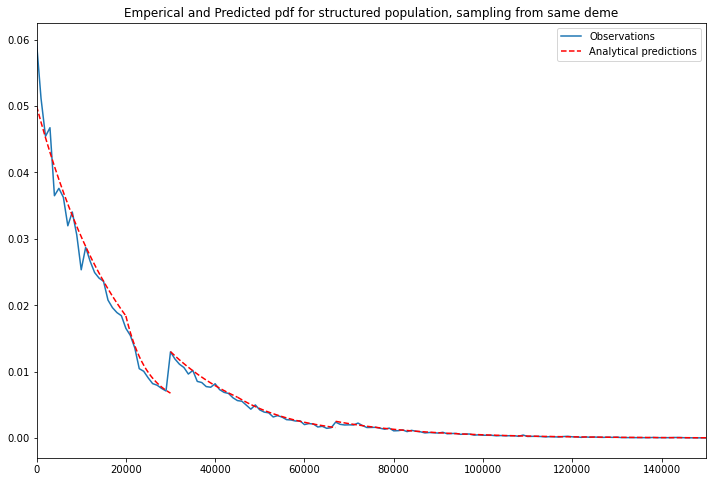

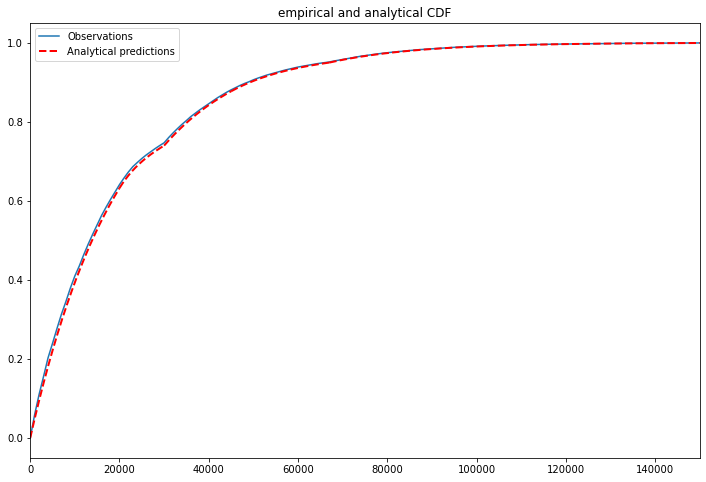

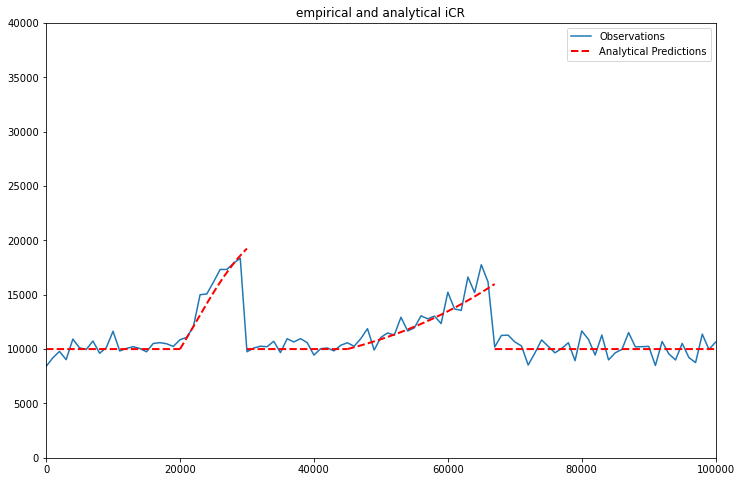

In [54]:
# set up parameters

N = 20000 # haploid genomes 
# n is number of demes
n = 2

# m1 is migration rate for first bout
m1 = mig_rate1
M1 = 2*N*m1
gamma1 = M1/(n-1)
mu = 2e-08
theta = 2 * N * mu 
discriminant1 = (1+n*gamma1)**2 - 4*gamma1
alpha1 = 0.5*(1 + n*gamma1 + np.sqrt(discriminant1))
beta1 = 0.5*(1 + n*gamma1 - np.sqrt(discriminant1))
a1 = (gamma1-alpha1)/(beta1-alpha1)
c1 = gamma1/(beta1-alpha1)

# m2 is migration rate for first bout
m2 = mig_rate2
M2 = 2*N*m2
gamma2 = M2/(n-1)
mu = 2e-08
theta = 2 * N * mu 
discriminant2 = (1+n*gamma2)**2 - 4*gamma2
alpha2 = 0.5*(1 + n*gamma2 + np.sqrt(discriminant2))
beta2 = 0.5*(1 + n*gamma2 - np.sqrt(discriminant2))
a2 = (gamma2-alpha2)/(beta2-alpha2)
c2 = gamma2/(beta2-alpha2)

print('M1, gamma1, theta, discriminant1, alpha1, beta1, a1, c1 are {}'.format([M1, gamma1, theta, discriminant1, alpha1, beta1, a1, c1]))
print('M2, gamma2, theta, discriminant2, alpha2, beta2, a2, c2 are {}'.format([M2, gamma2, theta, discriminant2, alpha2, beta2, a2, c2]))

def f_samedeme0(x,N):
    x = x/N
    f = np.exp(-x)
    return f*scaling

def F_samedeme0(x,N):
    x = x/N
    F = 1- np.exp(-x)
    return F

# equation 10
def f_samedeme1(x,a,alpha,beta,N,T_1):
    # if j is generations, do we scale with j/(number of haploid genomes) or ((num of demes)*j)/(number of haploid genomes)
    # i.e. x = j/N or x = (n*j)/N 
    # I tried both, neither fits data
    x = (x-T_1)/(N)
    bigger_f0 = 1 - F_samedeme0(T_1,N)
    T_1 = T_1/N
    f = a*np.exp(-alpha*x) + (1-a)*np.exp(-beta*x)
    return bigger_f0*f*scaling

def F_samedeme1(x,a,alpha,beta,N,T_1):
    x = (x-T_1)/N
    bigger_f0 = 1 - F_samedeme0(T_1,N)
    F = F_samedeme0(T_1,N) + (bigger_f0 + bigger_f0*((-a/alpha)*np.exp(-alpha*x) - ((1-a)/beta)*np.exp(-beta*x))) 
    return F
    
def f_samedeme2(x,a,alpha,beta,N,T_1,T_2):
    x = x/N
    bigger_f1 = 1 - F_samedeme1(T_2,a,alpha,beta,N,T_1) 
    T_2 = T_2/N
    f = bigger_f1*np.exp(-(x-T_2))
    return f*scaling
    
def F_samedeme2(x,a,alpha,beta,N,T_1,T_2):
    x = x/N
    bigger_f1 = 1 - F_samedeme1(T_2,a,alpha,beta,N,T_1)
    F = F_samedeme1(T_2,a,alpha,beta,N,T_1) + (bigger_f1-bigger_f1*np.exp(-(x-T_2/N)))
    return F

def f_samedeme3(x,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3):
    x = (x-T_3)/N
    bigger_f2 = 1 - F_samedeme2(T_3,a1,alpha1,beta1,N,T_1,T_2)
    f = a2*np.exp(-alpha2*x) + (1-a2)*np.exp(-beta2*x)
    return bigger_f2*f*scaling

def F_samedeme3(x,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3):
    x = (x-T_3)/N
    bigger_f3 = 1 - F_samedeme2(T_3,a1,alpha1,beta1,N,T_1,T_2)
    F = F_samedeme2(T_3,a1,alpha1,beta1,N,T_1,T_2) + (bigger_f3 + bigger_f3*((-a2/alpha2)*np.exp(-alpha2*x) - ((1-a2)/beta2)*np.exp(-beta2*x)))
    return F

def f_samedeme4(x,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3,T_4):
    x = x/N
    bigger_f3 = 1 - F_samedeme3(T_4,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3)
    T_4 = T_4/N
    f = bigger_f3*np.exp(-(x-T_4))
    return f*scaling

def F_samedeme4(x,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3,T_4):
    x = x/N
    bigger_f3 = 1 - F_samedeme3(T_4,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3)
    F = F_samedeme3(T_4,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3) + (bigger_f3-bigger_f3*np.exp(-(x-T_4/N)))
    return F

def iCR0(x,N):
    iCR = (1-F_samedeme0(x,N))/(2*f_samedeme0(x,N))*spacing
    return iCR

def iCR1(x,a,alpha,beta,N,T_1):
    iCR = (1-F_samedeme1(x,a,alpha,beta,N,T_1))/(2*f_samedeme1(x,a,alpha,beta,N,T_1))*spacing
    return iCR

def iCR2(x,a,alpha,beta,N,T_1,T_2):
    iCR = (1-F_samedeme2(x,a,alpha,beta,N,T_1,T_2))/(2*f_samedeme2(x,a,alpha,beta,N,T_1,T_2))*spacing
    return iCR

def iCR3(x,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3):
    iCR = (1-F_samedeme3(x,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3))/(2*f_samedeme3(x,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3))*spacing
    return iCR

def iCR4(x,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3,T_4):
    iCR = (1-F_samedeme4(x,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3,T_4))/(2*f_samedeme4(x,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3,T_4))*spacing
    return iCR
    

t1 = np.arange(0,T_1,1) # first epoch
t2 = np.arange(T_1,T_2,1) # first epoch
t3 = np.arange(T_2,T_3,1) # first epoch
t4 = np.arange(T_3,T_4,1) # first epoch
t5 = np.arange(T_4,max_time,1)

line_f_obs = plt.plot(time_intervals,f_obs8,label="Observations")
line_f0 = plt.plot(t1,f_samedeme0(t1,N),label="Analytical predictions",color="red",linestyle="dashed")
line_f1 = plt.plot(t2,f_samedeme1(t2,a1,alpha1,beta1,N,T_1),color="red",linestyle="dashed")
line_f2 = plt.plot(t3,f_samedeme2(t3,a1,alpha1,beta1,N,T_1,T_2),color="red",linestyle="dashed")
line_f3 = plt.plot(t4,f_samedeme3(t4,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3),color="red",linestyle="dashed")
line_f4 = plt.plot(t5,f_samedeme4(t5,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3,T_4),color="red",linestyle="dashed")
# line_f4 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf for structured population, sampling from same deme')
plt.show()

line_F_obs = plt.plot(time_intervals,F_obs8,label="Observations")
line_F0 = plt.plot(t1,F_samedeme0(t1,N),color = "red",label="Analytical predictions",linestyle="dashed",linewidth=2)
plt.plot(t2,F_samedeme1(t2,a1,alpha1,beta1,N,T_1),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t3,F_samedeme2(t3,a1,alpha1,beta1,N,T_1,T_2),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t4,F_samedeme3(t4,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t5,F_samedeme4(t5,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3,T_4),color = "red",linestyle="dashed",linewidth=2)
plt.title('empirical and analytical CDF')
plt.legend()
plt.xlim(0,150000)
plt.show()

line_ICR_obs = plt.plot(time_intervals,iCR_obs8,label="Observations")
line_ICR1 = plt.plot(t1,iCR0(t1,N),color = "red",linestyle="dashed",linewidth=2,label="Analytical Predictions")
plt.plot(t2,iCR1(t2,a,alpha,beta,N,T_1),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t3,iCR2(t3,a,alpha,beta,N,T_1,T_2),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t4,iCR3(t4,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3),color = "red",linestyle="dashed",linewidth=2)
plt.plot(t5,iCR4(t5,a1,alpha1,beta1,a2,alpha2,beta2,N,T_1,T_2,T_3,T_4),color = "red",linestyle="dashed",linewidth=2)

plt.xlim(0,100000)
plt.ylim(0,40000)
plt.legend()
plt.title('empirical and analytical iCR')
plt.show()

## TODO

Try with different rate of structure m < 5e-05 and with more than one deme,<br>
Try with population growth and structure

In [55]:
print('hello there!')

hello there!


In [30]:
test1 = G(T_np[5],T_np[10],gamma_array,lambda_array,T_np)
test2 = G(T_np[0],T_np[10],gamma_array,lambda_array,T_np)
test3 = G(T_np[0],T_np[5],gamma_array,lambda_array,T_np)

print('test1 is {}\ntest2 is {}\n test3 is {}\ntest2/test3 is {}'.format(test1,test2,test3,test2/test3))

test1 is 0.9614315398718107
test2 is 0.9088628947971044
 test3 is 0.9453225290677322
test2/test3 is 0.9614315398718107


In [56]:
def G_copynew(t1,t2,gamma_array,lambda_array,T):
    """
    Assume t1 = ind1 =  0
    Then G(t) = no coalescing between 0 and t
    So if you want G between t1 and t2, you can do G = G(t2)/G(t1)
    For non 0 t1, can do 
    Takes as input t1 and t2 in scaled coalescent time
    t1, t2: can be boundaries or some number between a boundary
    Needs also gamma_array and lambda_array

    t1, t2: can be boundaries or some number between a boundary
    T: array of time intervals in coalescent time
    lambda_array: array of lambdas where lambda_i = N_0/pop_size_i
    gamma_array: array of population split fractions per time


    """
    
    def delta(i):
        delt = T[i+1] - T[i]
        return delt
    def lower_higher_intervals(t1,t2):
        # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        if ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2


    def G_main(t2,ind1,ind2):
        # main part of G (the recursive part; the product); see my notepad page TODO
        recursion = 1
        i = ind1 # ind1 should be 0
        while i < ind2:
            sigma = ( (1-gamma_array[i])**2 + gamma_array[i]**2 )
            if (gamma_array[i] == gamma_array[i+1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                c = i # c for 'change', the point at which gamma changes
                G_set = np.array([])
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c]))
                G_set = np.append(G_set,G_temp)
                recursion = recursion*G_temp
                i += 1
                while gamma_array[i] == gamma_array[i+1] and i < ind2:
                    G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                    G_temp = G_temp/np.prod(G_set)
                    G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                    recursion = recursion*G_temp
                    i += 1
#                 recursion = recursion*np.prod(G_set)
            elif (gamma_array[i] != gamma_array[i+1]) and (gamma_array[i] == gamma_array[i-1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                G_temp = G_temp/np.prod(G_set)
                G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                recursion = recursion*G_temp
                i += 1
            elif (gamma_array[i] != gamma_array[i-1]) and (gamma_array[i] == 0 or gamma_array[i] == 1):
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            else: 
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            
#         G_end
#         either t2 is in interval i with sigma_i == sigma_{i-1}
#         or t2 is in interval i where sigma_i != sigma_{i-1}
        if gamma_array[ind2] == gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: # if t2 is in an interval where there is the same gamma as the previous
            G_temp = 1 - sigma + sigma*np.exp(-lambda_array[ind2]*(t2-T[c])) # TODO this lambda needs to be summed
            G_temp = G_temp/np.prod(G_set) # don't bother adding this G_temp to G_set
            recursion = recursion*G_temp
        elif gamma_array[ind2] != gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: 
#             pdb.set_trace()
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] != gamma_array[ind2-1] and (gamma_array[ind2] == 1 or gamma_array[ind2] == 0):
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] == 1 or gamma_array[ind2] == 0:
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        else: 
            print('there has been an error!')
        return recursion
    
    def G_same(t1,t2,ind1):
        # if t1 and t2 are within the same interval
        G = 1 - ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) ) + ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) )*np.exp(-(lambda_array[ind1]*(t2-t1) ))
        return G

    ind1, ind2 = lower_higher_intervals(t1,t2) # get the intervals in which t1 and t2 are situated
    if ind1 == ind2: # if they are in the same interval
        G = G_same(t1,t2,ind1) 
    #elif ind1 == (ind2-1): # if they are one interval apart
    #    G = G_start(t1,ind1)*G_end(t2,ind2)
    else: # otherwise; there is some distance between them
        if t1 != 0:
            G = G_main(t2,0,ind2) / G_main(t1,0,ind1)
        elif t1 == 0:
            G = G_main(t2,ind1,ind2)
    #         G_end_ = G_end(t2,ind2)
            #*G_end_
    #         print('G_start_ is {}\nG_main_ is {}\nG_end_ is {}'.format(G_start_,G_main_,G_end_))
    return G
    # TODO try this on my distribution till coalesence thingtime  
  

In [65]:
test1 = G_copynew(T_np[5],T_np[10],gamma_array,lambda_array,T_np)
test2 = G_copynew(T_np[0],T_np[10],gamma_array,lambda_array,T_np)
test3 = G_copynew(T_np[0],T_np[5],gamma_array,lambda_array,T_np)
print('test1 is {}\ntest2 is {}\n test3 is {}\ntest2/test3 is {}'.format(test1,test2,test3,test2/test3))

test4 = G_copynew(0.07,T_np[10],gamma_array,lambda_array,T_np)
test5 = G_copynew(T_np[0],T_np[10],gamma_array,lambda_array,T_np)
test6 = G_copynew(T_np[0],0.07,gamma_array,lambda_array,T_np)

print('\n\ntest4 is {}\ntest5 is {}\n test6 is {}\ntest5/test6 is {}'.format(test4,test5,test6,test5/test6))

test7 = G_copynew(0.07,0.111,gamma_array,lambda_array,T_np)
test8 = G_copynew(T_np[0],0.111,gamma_array,lambda_array,T_np)
test9 = G_copynew(T_np[0],0.07,gamma_array,lambda_array,T_np)

print('\n\ntest7 is {}\ntest8 is {}\n test9 is {}\ntest8/test9 is {}'.format(test7,test8,test9,test8/test9))

test10 = G_copynew(1.4,3.8,gamma_array,lambda_array,T_np)
test11 = G_copynew(0,3.8,gamma_array,lambda_array,T_np)
test12 = G_copynew(0,1.4,gamma_array,lambda_array,T_np)

print('\n\ntest10 is {}\ntest11 is {}\n test12 is {}\ntest11/test12 is {}'.format(test10,test11,test12,test11/test12))

a = 0.77
b = 1.913
c = (a+b)/2
test13 = G_copynew(a,b,gamma_array,lambda_array,T_np)**2
test14 = ( G_copynew(a,c,gamma_array,lambda_array,T_np)**2 ) * ( G_copynew(c,b,gamma_array,lambda_array,T_np)**2 )
test15 = test13 - test14
print('\n\ntest13 is {} and test14 is {} and test15 = {} '.format(test13,test14,test15))



test1 is 0.9614315398718107
test2 is 0.9088628947971044
 test3 is 0.9453225290677322
test2/test3 is 0.9614315398718107


test4 is 0.9747628903082848
test5 is 0.9088628947971044
 test6 is 0.9323938199059482
test5/test6 is 0.9747628903082848


test7 is 0.9598291299477989
test8 is 0.8949387489290309
 test9 is 0.9323938199059482
test8/test9 is 0.9598291299477989


test10 is 0.11329759759159856
test11 is 0.030521277042579693
 test12 is 0.2693903285804796
test11/test12 is 0.11329759759159856


test13 is 0.14124563138843657 and test14 is 0.1412456313884366 and test15 = -2.7755575615628914e-17 


In [63]:
gamma_array

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 0.1, 0.1, 0.1, 0.1, 0.1, 1. , 1. ,
       1. , 1. , 1. , 0.3, 1. , 1. , 1. , 1. , 1. , 1. , 1. ])